Generating a large dataset for ground truth...
Generating a small subset for estimator training...
Starting model training (on small dataset)...
Epoch 0, Loss: 22.3386
Epoch 40, Loss: 1.2726
Epoch 80, Loss: 0.1699
Epoch 120, Loss: 0.1154
Epoch 160, Loss: 0.0869
Model training complete.
Computing ground truth output distribution via high-density sampling...
Ground truth calculation complete.
Total possible covariance entries: 865, Initial diagonal entries: 49

--- Starting Greedy Search for Optimal Ordering (Based on Ground Truth) ---
Computing ground truth output distribution via high-density sampling...
Ground truth calculation complete.
Ordering Iteration 10: Found new best entry (0, 3, 6) -> KL Reduction: 0.291534
Ordering Iteration 20: Found new best entry (1, 16, 18) -> KL Reduction: 0.371659
Ordering Iteration 30: Found new best entry (1, 14, 22) -> KL Reduction: 0.274214
Ordering Iteration 40: Found new best entry (1, 19, 20) -> KL Reduction: 0.216906
Ordering Iteration 50: Foun

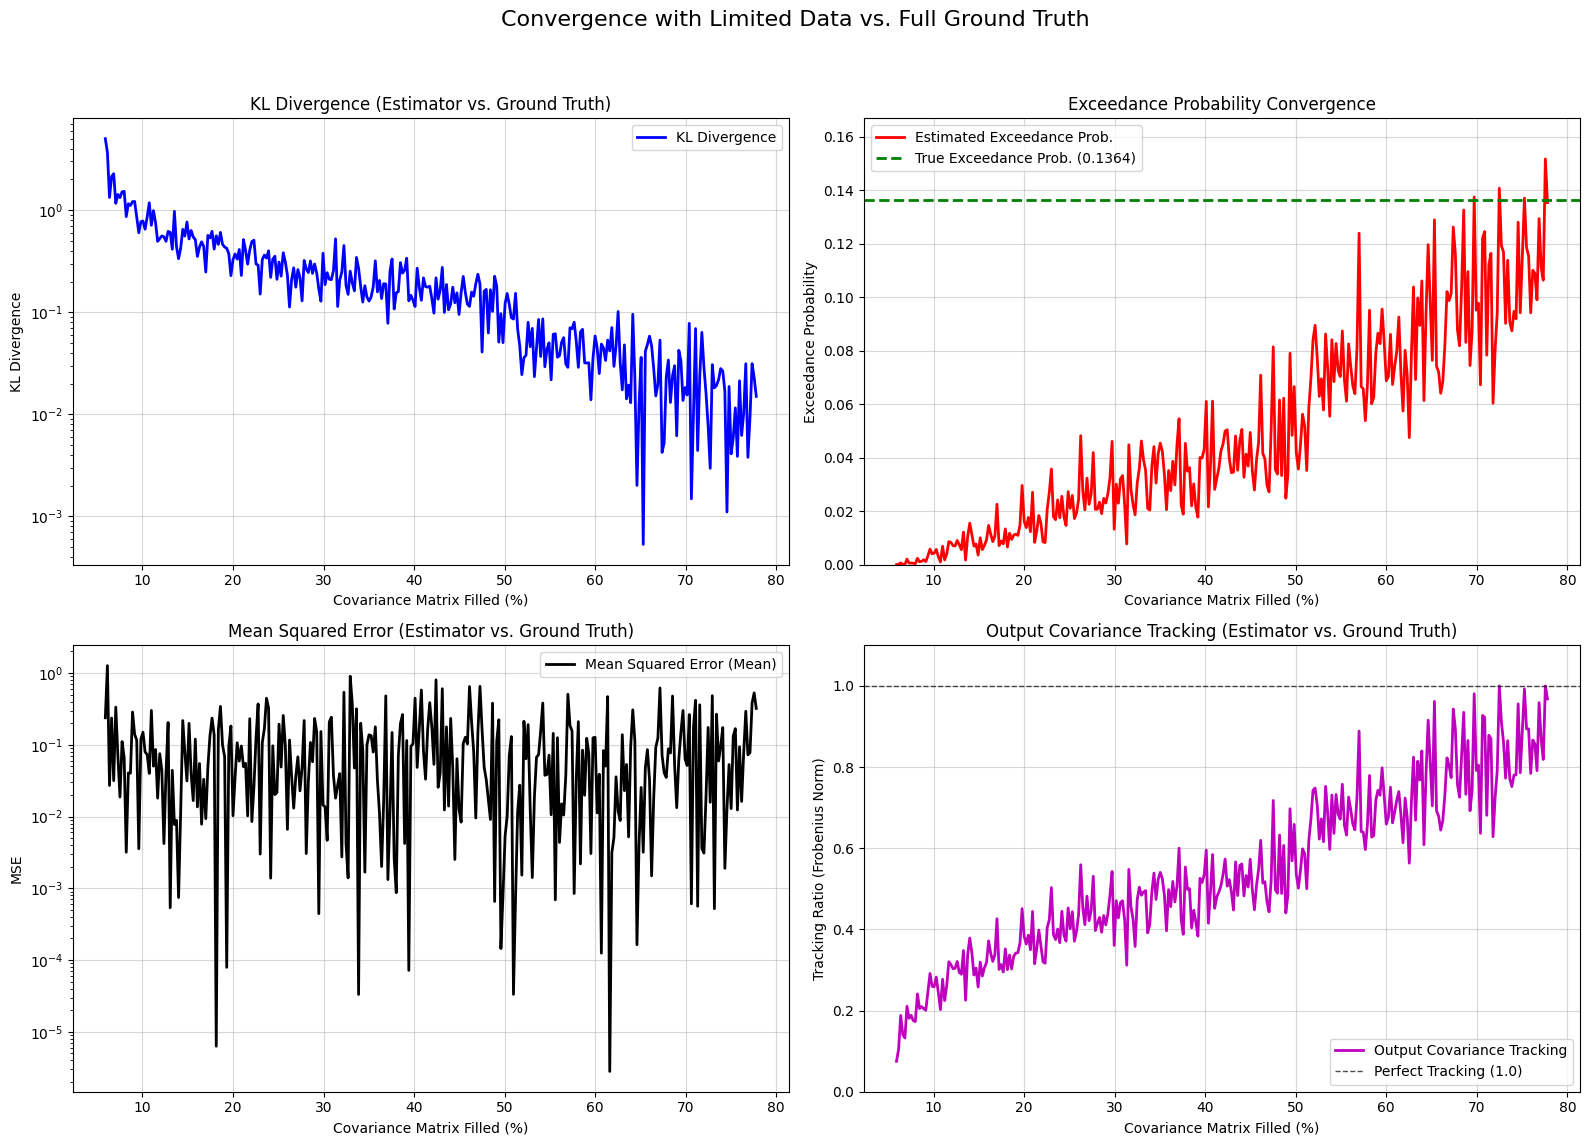


FINAL RESULTS: Estimator Trained on Small Subset
Final Percentage of Covariance Filled: 77.80%
Final KL Divergence to True Distribution: 0.014997
Final Mean Squared Error to True Mean: 0.321432
Final Estimated Exceedance Probability: 0.135333
Ground Truth Exceedance Probability: 0.136436
Error in Exceedance Probability: 0.001103
Final Covariance Tracking Ratio: 0.967984

Total Ground Truth Samples: 200000
Total Training Samples Seen by Estimator: 3120 (out of 2000 available)


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import os
from scipy.stats import norm
from torch.distributions import MultivariateNormal
import matplotlib.pyplot as plt
import copy

# Create output directory for visualizations
os.makedirs('training_visualizations', exist_ok=True)

class DeepNet(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(DeepNet, self).__init__()
        layers = []
        current_size = input_size
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(current_size, hidden_size))
            layers.append(nn.ReLU())
            current_size = hidden_size
        layers.append(nn.Linear(current_size, output_size))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

class FactorGaussian:
    def __init__(self, mean, L_factor, diagonal):
        """Σ = L @ L.T + diag(diagonal)"""
        self.mean = mean
        self.L = L_factor
        self.diagonal = diagonal
        self.n = len(mean)
        self.current_rank = L_factor.shape[1]

    def covariance(self):
        stable_diagonal = self.diagonal + 1e-8
        return self.L @ self.L.T + torch.diag(stable_diagonal)

    def get_diagonal(self):
        l_diag = torch.sum(self.L * self.L, dim=1)
        return l_diag + self.diagonal

def propagate_by_sampling(input_distribution, layer_block, mask=None, num_samples=1000):
    input_mean = input_distribution.mean
    input_cov = input_distribution.covariance()
    input_dim = input_mean.shape[0]
    
    epsilon = 1e-6 * torch.eye(input_dim, device=input_mean.device)
    input_dist_sampler = MultivariateNormal(loc=input_mean, covariance_matrix=input_cov + epsilon)
    samples = input_dist_sampler.sample(torch.Size([num_samples]))
    with torch.no_grad():
        output_samples = layer_block(samples)
    
    output_mean = torch.mean(output_samples, dim=0)
    mean_subtracted_output = output_samples - output_mean
    full_output_covariance = (1 / (num_samples - 1)) * mean_subtracted_output.T @ mean_subtracted_output

    # The mask is now a set of tuples (row, col)
    # Default to a full mask if None is provided
    if mask is None:
        output_dim = full_output_covariance.shape[0]
        mask = set((r, c) for r in range(output_dim) for c in range(output_dim))

    masked_cov = torch.zeros_like(full_output_covariance)
    for r, c in mask:
        if r < masked_cov.shape[0] and c < masked_cov.shape[1]:
            masked_cov[r, c] = full_output_covariance[r, c]
            if r != c: # Ensure symmetry
                masked_cov[c, r] = full_output_covariance[c, r]

    output_diag = torch.diag(full_output_covariance)
    off_diag_cov = masked_cov - torch.diag(torch.diag(masked_cov))
    
    try:
        eigvals, eigvecs = torch.linalg.eigh(off_diag_cov)
        eigvals_positive = torch.clamp(eigvals, min=0)
        sqrt_eigvals = torch.sqrt(eigvals_positive)
        output_L = eigvecs @ torch.diag(sqrt_eigvals)
    except torch.linalg.LinAlgError:
        output_L = torch.zeros_like(off_diag_cov)

    # The diagonal of the FactorGaussian should be the residual variance
    # not captured by L@L.T
    residual_diag = output_diag - torch.sum(output_L * output_L, dim=1)
    
    return FactorGaussian(mean=output_mean, L_factor=output_L, diagonal=torch.clamp(residual_diag, min=0))


def compute_estimator_kl_div(true_output_distribution, predicted_output_distribution):
    mu_true, mu_pred = true_output_distribution.mean, predicted_output_distribution.mean
    sigma_true = true_output_distribution.covariance().detach().cpu().numpy()
    sigma_pred = predicted_output_distribution.covariance().detach().cpu().numpy()
    mu_true, mu_pred = mu_true.detach().cpu().numpy(), mu_pred.detach().cpu().numpy()

    epsilon = 1e-6 * np.eye(sigma_true.shape[0])
    sigma_true_stable, sigma_pred_stable = sigma_true + epsilon, sigma_pred + epsilon

    mu_diff = mu_pred - mu_true
    k = len(mu_true)
    try:
        sigma_pred_inv = np.linalg.inv(sigma_pred_stable)
        trace_term = np.trace(sigma_pred_inv @ sigma_true_stable)
        quad_term = mu_diff.T @ sigma_pred_inv @ mu_diff
        sign_true, logdet_true = np.linalg.slogdet(sigma_true_stable)
        sign_pred, logdet_pred = np.linalg.slogdet(sigma_pred_stable)
        if sign_true <= 0 or sign_pred <= 0: return float('inf')
        log_det_term = logdet_pred - logdet_true
        return 0.5 * (trace_term + quad_term - k + log_det_term)
    except np.linalg.LinAlgError:
        return float('inf')

def compute_estimator_mse(true_output_distribution, predicted_output_distribution):
    true_mean = true_output_distribution.mean
    predicted_mean = predicted_output_distribution.mean
    mse = torch.mean((true_mean - predicted_mean) ** 2)
    return mse.item()

def find_true_distribution_by_sampling(input_distribution, grouped_layers, num_samples=50000):
    print("Computing ground truth output distribution via high-density sampling...")
    current_distribution = input_distribution
    for layer_block in grouped_layers:
        current_distribution = propagate_by_sampling(current_distribution, layer_block, mask=None, num_samples=num_samples)
    print("Ground truth calculation complete.")
    return current_distribution

def calculate_range_exceedance_probability(distribution, lower_bound=-5, upper_bound=5):
    # This function now correctly handles multi-dimensional output by focusing on the first dimension
    if distribution.mean.dim() == 0: # If output is scalar
        mu = distribution.mean.item()
        variance = distribution.get_diagonal().item()
    else: # If output is a vector, use the first element
        mu = distribution.mean[0].item()
        variance = distribution.get_diagonal()[0].item()
        
    sigma = np.sqrt(max(variance, 1e-9))
    prob_below = norm.cdf(lower_bound, loc=mu, scale=sigma)
    prob_above = 1 - norm.cdf(upper_bound, loc=mu, scale=sigma)
    return prob_below + prob_above

def calculate_covariance_tracking_ratio(true_distribution, estimated_distribution):
    true_cov = true_distribution.covariance().detach().cpu().numpy()
    est_cov = estimated_distribution.covariance().detach().cpu().numpy()
    
    true_norm = np.linalg.norm(true_cov, 'fro')
    est_norm = np.linalg.norm(est_cov, 'fro')
    
    if true_norm == 0:
        return 1.0 if est_norm == 0 else 0.0
    return min(est_norm / true_norm, 1.0)

def calculate_total_mask_entries(masks):
    return sum(len(mask) for mask in masks)

def calculate_total_possible_entries(grouped_layers):
    total = 0
    for block in grouped_layers:
        output_dim = get_output_dim_from_block(block)
        total += output_dim * output_dim
    return total

def update_mean_covariance(existing_mean, existing_cov, existing_n, new_data):
    new_n = new_data.shape[0]
    if new_n == 0:
        return existing_mean, existing_cov, existing_n
        
    total_n = existing_n + new_n
    if existing_n == 0:
        new_mean = torch.mean(new_data, dim=0)
        new_cov = torch.cov(new_data.T) if new_n > 1 else torch.zeros_like(existing_cov)
        return new_mean, new_cov, total_n

    new_batch_mean = torch.mean(new_data, dim=0)
    delta = new_batch_mean - existing_mean
    updated_mean = existing_mean + delta * (new_n / total_n)
    
    new_batch_cov = torch.cov(new_data.T) if new_n > 1 else torch.zeros_like(existing_cov)
    updated_cov = ((existing_n - 1) * existing_cov + (new_n - 1) * new_batch_cov + 
                   (new_n * existing_n / total_n) * (delta.unsqueeze(1) @ delta.unsqueeze(0))) / (total_n - 1)

    return updated_mean, updated_cov, total_n


def get_output_dim_from_block(layer_block):
    for layer in reversed(layer_block):
        if hasattr(layer, 'out_features'):
            return layer.out_features
    raise ValueError("Could not find a layer with 'out_features' in the block.")

def update_mask_with_ordering(masks, ordering, step):
    if step < len(ordering):
        layer_idx, i, j = ordering[step]
        if isinstance(masks[layer_idx], list):
            masks[layer_idx] = set(masks[layer_idx])
        masks[layer_idx].add((i, j))
        if i != j:
            masks[layer_idx].add((j, i))
    return masks

def create_perfect_ordering(true_input_dist, model, initial_masks):
    print("\n--- Starting Greedy Search for Optimal Ordering (Based on Ground Truth) ---")
    grouped_layers = []
    temp_block_list = []
    for layer in model.layers:
        temp_block_list.append(layer)
        if isinstance(layer, nn.ReLU):
            grouped_layers.append(nn.Sequential(*temp_block_list))
            temp_block_list = []
    if temp_block_list:
        grouped_layers.append(nn.Sequential(*temp_block_list))

    true_output_distribution = find_true_distribution_by_sampling(true_input_dist, grouped_layers, num_samples=100000)

    current_masks = [set(m) for m in initial_masks]
    optimal_ordering = []
    max_iterations = 2000
    propagation_samples = 1000

    for iteration in range(max_iterations):
        best_choice_this_iteration = None
        best_kl_reduction = 0  # We want to maximize the KL reduction

        base_dist = true_input_dist
        for l_idx, l_block in enumerate(grouped_layers):
            base_dist = propagate_by_sampling(base_dist, l_block, mask=current_masks[l_idx], num_samples=propagation_samples)
        base_kl = compute_estimator_kl_div(true_output_distribution, base_dist)
        
        candidate_found = False
        for layer_idx, layer_block in enumerate(grouped_layers):
            output_dim = get_output_dim_from_block(layer_block)
            for i in range(output_dim):
                for j in range(i, output_dim):
                    if (i, j) in current_masks[layer_idx]:
                        continue

                    temp_masks = [m.copy() for m in current_masks]
                    temp_masks[layer_idx].add((i, j))
                    if i != j: temp_masks[layer_idx].add((j, i))
                    
                    current_dist = true_input_dist
                    for l_idx_prop, l_block_prop in enumerate(grouped_layers):
                        current_dist = propagate_by_sampling(current_dist, l_block_prop, mask=temp_masks[l_idx_prop], num_samples=propagation_samples)
                    
                    kl = compute_estimator_kl_div(true_output_distribution, current_dist)
                    kl_reduction = base_kl - kl

                    if kl_reduction > best_kl_reduction:
                        best_kl_reduction = kl_reduction
                        best_choice_this_iteration = (layer_idx, i, j)
                        candidate_found = True
        
        if candidate_found:
            layer_to_update, r, c = best_choice_this_iteration
            optimal_ordering.append(best_choice_this_iteration)
            current_masks[layer_to_update].add((r, c))
            if r != c: current_masks[layer_to_update].add((c, r))
            if (iteration + 1) % 10 == 0:
                print(f"Ordering Iteration {iteration+1}: Found new best entry {best_choice_this_iteration} -> KL Reduction: {best_kl_reduction:.6f}")
        else:
            print(f"\nStopping greedy search at iteration {iteration+1}. No further beneficial entries found.")
            break

    print(f"--- Greedy Search Complete. Found an ordering of {len(optimal_ordering)} entries. ---\n")
    return optimal_ordering

# --- 1. Setup: Ground Truth vs. Training Data ---
torch.manual_seed(42)
np.random.seed(42)
input_dim = 3
base_input_mean = torch.zeros(input_dim, dtype=torch.float32)
base_input_covariance = torch.tensor([[1.0, 0.7, 0.3], [0.7, 1.5, 0.8], [0.3, 0.8, 2.0]], dtype=torch.float32)
base_input_sampler = MultivariateNormal(loc=base_input_mean, covariance_matrix=base_input_covariance)

# Generate a large dataset for GROUND TRUTH
print("Generating a large dataset for ground truth...")
X_ground_truth = base_input_sampler.sample(torch.Size([200000]))
true_input_mean = torch.mean(X_ground_truth, dim=0)
true_input_covariance = torch.cov(X_ground_truth.T)
true_input_L = torch.linalg.cholesky(true_input_covariance)
true_input_diag = torch.zeros(input_dim)
true_input_distribution_full = FactorGaussian(mean=true_input_mean, L_factor=true_input_L, diagonal=true_input_diag)

# Generate a small dataset for TRAINING the ESTIMATOR
print("Generating a small subset for estimator training...")
X_train = base_input_sampler.sample(torch.Size([2000])) # Estimator only sees this
true_weights = torch.tensor([[2.0], [3.0], [-1.0]], dtype=torch.float32)
y_train = X_train @ true_weights # Model is trained on the small dataset too

# --- 2. Model Training (Done Once on the small dataset) ---
model = DeepNet(input_size=3, hidden_sizes=[12, 24, 12], output_size=1)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
print("Starting model training (on small dataset)...")
for epoch in range(200):
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    if epoch % 40 == 0: print(f'Epoch {epoch}, Loss: {loss.item():.4f}')
print("Model training complete.")
model.eval()

# --- 3. Pre-computation Using GROUND TRUTH Data ---
grouped_layers = []
temp_block_list = []
for layer in model.layers:
    temp_block_list.append(layer)
    if isinstance(layer, nn.ReLU):
        grouped_layers.append(nn.Sequential(*temp_block_list))
        temp_block_list = []
if temp_block_list: grouped_layers.append(nn.Sequential(*temp_block_list))

# Find the TRUE output distribution using the FULL ground truth input distribution
true_output_distribution = find_true_distribution_by_sampling(true_input_distribution_full, grouped_layers, num_samples=200000)
true_exceedance_prob = calculate_range_exceedance_probability(true_output_distribution)

total_possible_entries = calculate_total_possible_entries(grouped_layers)
initial_masks = []
initial_entries = 0
for block in grouped_layers:
    dim = get_output_dim_from_block(block)
    initial_masks.append(set((i, i) for i in range(dim)))
    initial_entries += dim
print(f"Total possible covariance entries: {total_possible_entries}, Initial diagonal entries: {initial_entries}")

# Run greedy search using the FULL ground truth distribution
optimal_ordering = create_perfect_ordering(true_input_distribution_full, model, initial_masks)
num_training_steps = len(optimal_ordering)

# --- 4. Sequential Simulation Loop (Using TRAINING Data) ---
samples_per_step = 10
propagation_samples = 500
total_samples_seen = 0
estimated_input_mean_raw = torch.zeros(input_dim)
estimated_input_covariance_raw = torch.zeros(input_dim, input_dim)
history_kl, history_exceedance_prob, history_mse, history_covariance_tracking_ratio, history_percent_filled = [], [], [], [], []

masks = [set(m) for m in initial_masks]

print(f"\n--- Starting Sequential Simulation ({num_training_steps} steps) ---")
print("Estimator will only see samples from the small training set.")
for step in range(num_training_steps):
    # Fetch a small batch of new samples FROM THE TRAINING SET
    start_idx = total_samples_seen % (len(X_train) - samples_per_step)
    new_samples = X_train[start_idx : start_idx + samples_per_step]
    
    # Update the estimator's view of the input distribution
    estimated_input_mean_raw, estimated_input_covariance_raw, total_samples_seen = update_mean_covariance(estimated_input_mean_raw, estimated_input_covariance_raw, total_samples_seen, new_samples)
    
    masks = update_mask_with_ordering(masks, optimal_ordering, step)
    
    if total_samples_seen > 1:
        current_entries = calculate_total_mask_entries(masks)
        current_percent = (current_entries / total_possible_entries) * 100
        
        epsilon_diag = 1e-6 * torch.eye(input_dim)
        try:
            # Create the estimator's input distribution from its limited knowledge
            L = torch.linalg.cholesky(estimated_input_covariance_raw + epsilon_diag)
            diag = torch.zeros(input_dim)
            estimated_input_dist = FactorGaussian(mean=estimated_input_mean_raw, L_factor=L, diagonal=diag)
        except torch.linalg.LinAlgError:
            L = torch.zeros((input_dim, 1))
            diag = torch.diag(estimated_input_covariance_raw)
            estimated_input_dist = FactorGaussian(mean=estimated_input_mean_raw, L_factor=L, diagonal=diag)

        # Propagate the ESTIMATED distribution
        current_dist = estimated_input_dist
        for layer_idx, layer_block in enumerate(grouped_layers):
            current_dist = propagate_by_sampling(current_dist, layer_block, mask=masks[layer_idx], num_samples=propagation_samples)
        
        estimated_output_distribution = current_dist
        
        # Compare ESTIMATED output against the TRUE output
        kl_div = compute_estimator_kl_div(true_output_distribution, estimated_output_distribution)
        mse = compute_estimator_mse(true_output_distribution, estimated_output_distribution)
        exceedance_prob = calculate_range_exceedance_probability(estimated_output_distribution)
        covariance_tracking_ratio = calculate_covariance_tracking_ratio(true_output_distribution, estimated_output_distribution)
        
        history_percent_filled.append(current_percent)
        history_kl.append(kl_div)
        history_mse.append(mse)
        history_exceedance_prob.append(exceedance_prob)
        history_covariance_tracking_ratio.append(covariance_tracking_ratio)

        if (step + 1) % 100 == 0 or (step + 1) == num_training_steps:
            print(f"Step {step+1}: {current_percent:.2f}% filled, KL Div = {kl_div:.4f}, Est. Exceedance = {exceedance_prob:.4f} (True: {true_exceedance_prob:.4f}), Cov. Ratio = {covariance_tracking_ratio:.4f}")

print("Simulation complete.")

# --- 5. Visualization ---
print("Generating visualizations...")
history_kl = np.array(history_kl)
history_exceedance_prob = np.array(history_exceedance_prob)
history_mse = np.array(history_mse)
history_covariance_tracking_ratio = np.array(history_covariance_tracking_ratio)
history_percent_filled = np.array(history_percent_filled)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Convergence with Limited Data vs. Full Ground Truth', fontsize=16)

# KL Divergence
axes[0, 0].plot(history_percent_filled, history_kl, 'b-', linewidth=2, label='KL Divergence')
axes[0, 0].set_xlabel('Covariance Matrix Filled (%)')
axes[0, 0].set_ylabel('KL Divergence')
axes[0, 0].set_title('KL Divergence (Estimator vs. Ground Truth)')
axes[0, 0].grid(True, alpha=0.5)
axes[0, 0].legend()
axes[0, 0].set_yscale('log')

# Exceedance Probability
axes[0, 1].plot(history_percent_filled, history_exceedance_prob, 'r-', linewidth=2, label='Estimated Exceedance Prob.')
axes[0, 1].axhline(y=true_exceedance_prob, color='g', linestyle='--', linewidth=2, label=f'True Exceedance Prob. ({true_exceedance_prob:.4f})')
axes[0, 1].set_xlabel('Covariance Matrix Filled (%)')
axes[0, 1].set_ylabel('Exceedance Probability')
axes[0, 1].set_title('Exceedance Probability Convergence')
axes[0, 1].grid(True, alpha=0.5)
axes[0, 1].legend()
axes[0, 1].set_ylim(bottom=min(0, np.min(history_exceedance_prob)*0.9), top=max(true_exceedance_prob*1.1, np.max(history_exceedance_prob)*1.1))


# MSE
axes[1, 0].plot(history_percent_filled, history_mse, 'k-', linewidth=2, label='Mean Squared Error (Mean)')
axes[1, 0].set_xlabel('Covariance Matrix Filled (%)')
axes[1, 0].set_ylabel('MSE')
axes[1, 0].set_title('Mean Squared Error (Estimator vs. Ground Truth)')
axes[1, 0].grid(True, alpha=0.5)
axes[1, 0].legend()
axes[1, 0].set_yscale('log')

# Covariance Tracking Ratio
axes[1, 1].plot(history_percent_filled, history_covariance_tracking_ratio, 'm-', linewidth=2, label='Output Covariance Tracking')
axes[1, 1].axhline(y=1.0, color='k', linestyle='--', linewidth=1, alpha=0.7, label='Perfect Tracking (1.0)')
axes[1, 1].set_xlabel('Covariance Matrix Filled (%)')
axes[1, 1].set_ylabel('Tracking Ratio (Frobenius Norm)')
axes[1, 1].set_title('Output Covariance Tracking (Estimator vs. Ground Truth)')
axes[1, 1].grid(True, alpha=0.5)
axes[1, 1].legend()
axes[1, 1].set_ylim(0, 1.1)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('training_visualizations/convergence_limited_data_vs_truth.png', dpi=300, bbox_inches='tight')
plt.show()

# --- Final Results ---
print("\n" + "="*60)
print("FINAL RESULTS: Estimator Trained on Small Subset")
print("="*60)
if len(history_percent_filled) > 0:
    print(f"Final Percentage of Covariance Filled: {history_percent_filled[-1]:.2f}%")
    print(f"Final KL Divergence to True Distribution: {history_kl[-1]:.6f}")
    print(f"Final Mean Squared Error to True Mean: {history_mse[-1]:.6f}")
    print(f"Final Estimated Exceedance Probability: {history_exceedance_prob[-1]:.6f}")
    print(f"Ground Truth Exceedance Probability: {true_exceedance_prob:.6f}")
    print(f"Error in Exceedance Probability: {abs(history_exceedance_prob[-1] - true_exceedance_prob):.6f}")
    print(f"Final Covariance Tracking Ratio: {history_covariance_tracking_ratio[-1]:.6f}")
else:
    print("No metric data was generated.")

print(f"\nTotal Ground Truth Samples: {len(X_ground_truth)}")
print(f"Total Training Samples Seen by Estimator: {total_samples_seen} (out of {len(X_train)} available)")
print("="*60)

Generating a large dataset for ground truth...
Generating a small subset for estimator training...
Starting model training (on small dataset)...
Epoch 0, Loss: 22.3386
Epoch 40, Loss: 1.2726
Epoch 80, Loss: 0.1699
Epoch 120, Loss: 0.1154
Epoch 160, Loss: 0.0869
Model training complete.
Computing ground truth output distribution via high-density sampling...
Ground truth calculation complete.

Computing vanilla output distribution from training samples...
Vanilla distribution calculation complete.

--- Starting Greedy Search for Optimal Ordering (Based on Ground Truth) ---
Computing ground truth output distribution via high-density sampling...
Ground truth calculation complete.
Ordering Iteration 10: Found new best entry (0, 3, 6) -> KL Reduction: 0.291534
Ordering Iteration 20: Found new best entry (1, 16, 18) -> KL Reduction: 0.371659
Ordering Iteration 30: Found new best entry (1, 14, 22) -> KL Reduction: 0.274214
Ordering Iteration 40: Found new best entry (1, 19, 20) -> KL Reduction

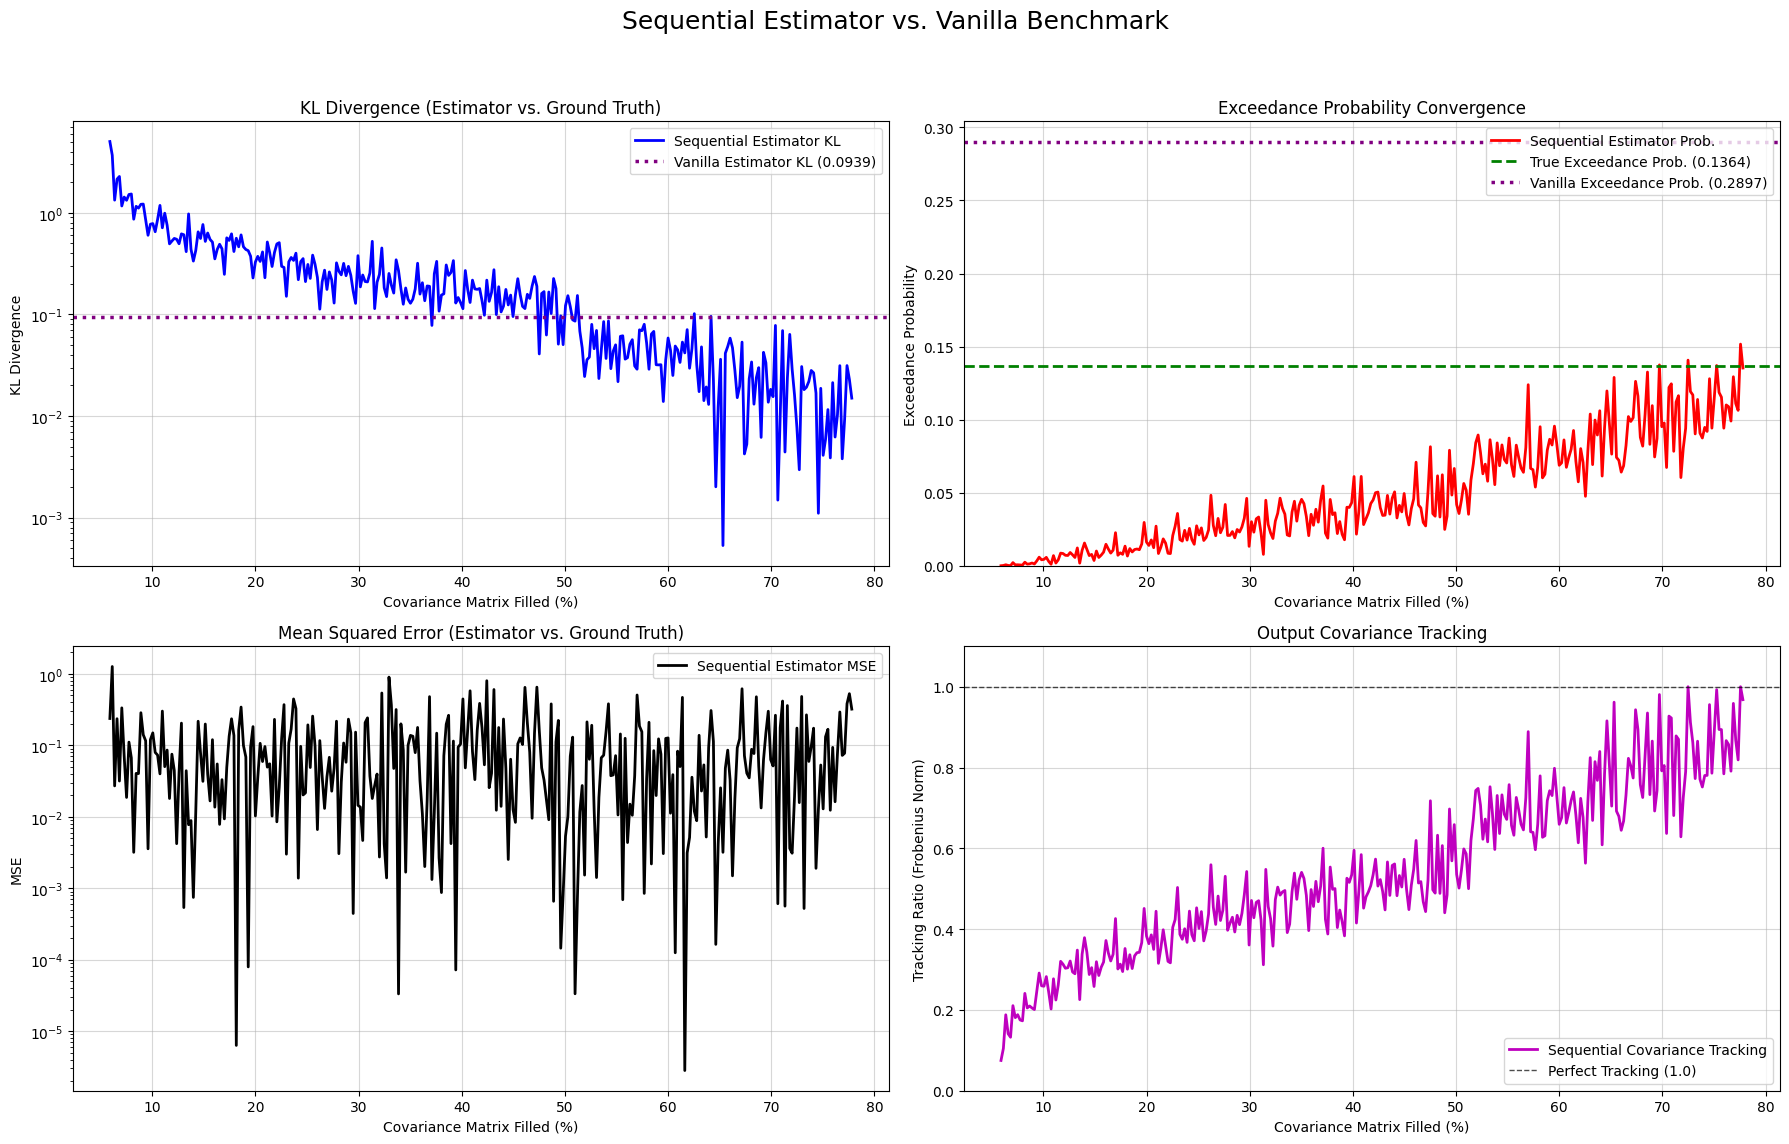


FINAL RESULTS: COMPARISON OF ESTIMATION METHODS
Ground Truth Exceedance Probability: 0.136436
----------------------------------------------------------------------
--- Vanilla Estimator (Based on all 2000 training samples at once) ---
Exceedance Probability: 0.289692
  > Error vs. True Prob: 0.153256
KL Divergence to True Distribution: 0.093869
----------------------------------------------------------------------
--- Sequential Estimator (Final State) ---
Final Percentage of Covariance Filled: 77.80%
Exceedance Probability: 0.135333
  > Error vs. True Prob: 0.001103
KL Divergence to True Distribution: 0.014997
Final Covariance Tracking Ratio: 0.967984

Total Ground Truth Samples: 200000
Total Training Samples for Estimators: 2000


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import os
from scipy.stats import norm
from torch.distributions import MultivariateNormal
import matplotlib.pyplot as plt
import copy

# Create output directory for visualizations
os.makedirs('training_visualizations', exist_ok=True)

class DeepNet(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(DeepNet, self).__init__()
        layers = []
        current_size = input_size
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(current_size, hidden_size))
            layers.append(nn.ReLU())
            current_size = hidden_size
        layers.append(nn.Linear(current_size, output_size))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

class FactorGaussian:
    def __init__(self, mean, L_factor, diagonal):
        """Σ = L @ L.T + diag(diagonal)"""
        self.mean = mean
        self.L = L_factor
        self.diagonal = diagonal
        self.n = len(mean)
        self.current_rank = L_factor.shape[1]

    def covariance(self):
        stable_diagonal = self.diagonal + 1e-8
        return self.L @ self.L.T + torch.diag(stable_diagonal)

    def get_diagonal(self):
        l_diag = torch.sum(self.L * self.L, dim=1)
        return l_diag + self.diagonal

def propagate_by_sampling(input_distribution, layer_block, mask=None, num_samples=1000):
    input_mean = input_distribution.mean
    input_cov = input_distribution.covariance()
    input_dim = input_mean.shape[0]
    
    epsilon = 1e-6 * torch.eye(input_dim, device=input_mean.device)
    input_dist_sampler = MultivariateNormal(loc=input_mean, covariance_matrix=input_cov + epsilon)
    samples = input_dist_sampler.sample(torch.Size([num_samples]))
    with torch.no_grad():
        output_samples = layer_block(samples)
    
    output_mean = torch.mean(output_samples, dim=0)
    mean_subtracted_output = output_samples - output_mean
    full_output_covariance = (1 / (num_samples - 1)) * mean_subtracted_output.T @ mean_subtracted_output

    if mask is None:
        output_dim = full_output_covariance.shape[0]
        mask = set((r, c) for r in range(output_dim) for c in range(output_dim))

    masked_cov = torch.zeros_like(full_output_covariance)
    for r, c in mask:
        if r < masked_cov.shape[0] and c < masked_cov.shape[1]:
            masked_cov[r, c] = full_output_covariance[r, c]
            if r != c:
                masked_cov[c, r] = full_output_covariance[c, r]

    output_diag = torch.diag(full_output_covariance)
    off_diag_cov = masked_cov - torch.diag(torch.diag(masked_cov))
    
    try:
        eigvals, eigvecs = torch.linalg.eigh(off_diag_cov)
        eigvals_positive = torch.clamp(eigvals, min=0)
        sqrt_eigvals = torch.sqrt(eigvals_positive)
        output_L = eigvecs @ torch.diag(sqrt_eigvals)
    except torch.linalg.LinAlgError:
        output_L = torch.zeros_like(off_diag_cov)

    residual_diag = output_diag - torch.sum(output_L * output_L, dim=1)
    
    return FactorGaussian(mean=output_mean, L_factor=output_L, diagonal=torch.clamp(residual_diag, min=0))


def compute_estimator_kl_div(true_output_distribution, predicted_output_distribution):
    mu_true, mu_pred = true_output_distribution.mean, predicted_output_distribution.mean
    sigma_true = true_output_distribution.covariance().detach().cpu().numpy()
    sigma_pred = predicted_output_distribution.covariance().detach().cpu().numpy()
    mu_true, mu_pred = mu_true.detach().cpu().numpy(), mu_pred.detach().cpu().numpy()

    epsilon = 1e-6 * np.eye(sigma_true.shape[0])
    sigma_true_stable, sigma_pred_stable = sigma_true + epsilon, sigma_pred + epsilon

    mu_diff = mu_pred - mu_true
    k = len(mu_true)
    try:
        sigma_pred_inv = np.linalg.inv(sigma_pred_stable)
        trace_term = np.trace(sigma_pred_inv @ sigma_true_stable)
        quad_term = mu_diff.T @ sigma_pred_inv @ mu_diff
        sign_true, logdet_true = np.linalg.slogdet(sigma_true_stable)
        sign_pred, logdet_pred = np.linalg.slogdet(sigma_pred_stable)
        if sign_true <= 0 or sign_pred <= 0: return float('inf')
        log_det_term = logdet_pred - logdet_true
        return 0.5 * (trace_term + quad_term - k + log_det_term)
    except np.linalg.LinAlgError:
        return float('inf')

def compute_estimator_mse(true_output_distribution, predicted_output_distribution):
    true_mean = true_output_distribution.mean
    predicted_mean = predicted_output_distribution.mean
    mse = torch.mean((true_mean - predicted_mean) ** 2)
    return mse.item()

def find_true_distribution_by_sampling(input_distribution, grouped_layers, num_samples=50000):
    print("Computing ground truth output distribution via high-density sampling...")
    current_distribution = input_distribution
    for layer_block in grouped_layers:
        current_distribution = propagate_by_sampling(current_distribution, layer_block, mask=None, num_samples=num_samples)
    print("Ground truth calculation complete.")
    return current_distribution

def find_vanilla_output_distribution(model, input_samples):
    """
    Computes the output distribution by passing all input_samples through the model
    and calculating the statistics of the output. This is the "vanilla" approach.
    """
    print("\nComputing vanilla output distribution from training samples...")
    with torch.no_grad():
        output_samples = model(input_samples)
    
    # Calculate mean and covariance from the output samples
    vanilla_mean = torch.mean(output_samples, dim=0)
    vanilla_cov = torch.cov(output_samples.T) if output_samples.shape[0] > 1 else torch.zeros(output_samples.shape[1], output_samples.shape[1])
    
    # If the output is 1D, torch.cov returns a 0-dim tensor (scalar).
    # We need to reshape it to a 1x1 matrix for consistency.
    if vanilla_cov.dim() == 0:
        vanilla_cov = vanilla_cov.reshape(1, 1)

    # Decompose into FactorGaussian format (L @ L.T + D)
    # For this simple case, we can use Cholesky on the full covariance
    # and set the diagonal part to zero.
    try:
        epsilon_diag = 1e-6 * torch.eye(vanilla_cov.shape[0], device=vanilla_cov.device)
        vanilla_L = torch.linalg.cholesky(vanilla_cov + epsilon_diag)
        vanilla_diag = torch.zeros(vanilla_mean.shape[0], device=vanilla_mean.device)
    except torch.linalg.LinAlgError:
        # If not positive definite, fall back to a diagonal representation
        vanilla_L = torch.zeros_like(vanilla_cov)
        vanilla_diag = torch.diag(vanilla_cov)

    print("Vanilla distribution calculation complete.")
    return FactorGaussian(mean=vanilla_mean, L_factor=vanilla_L, diagonal=vanilla_diag)


def calculate_range_exceedance_probability(distribution, lower_bound=-5, upper_bound=5):
    if distribution.mean.dim() == 0:
        mu = distribution.mean.item()
        variance = distribution.get_diagonal().item()
    else:
        mu = distribution.mean[0].item()
        variance = distribution.get_diagonal()[0].item()
        
    sigma = np.sqrt(max(variance, 1e-9))
    prob_below = norm.cdf(lower_bound, loc=mu, scale=sigma)
    prob_above = 1 - norm.cdf(upper_bound, loc=mu, scale=sigma)
    return prob_below + prob_above

def calculate_covariance_tracking_ratio(true_distribution, estimated_distribution):
    true_cov = true_distribution.covariance().detach().cpu().numpy()
    est_cov = estimated_distribution.covariance().detach().cpu().numpy()
    
    true_norm = np.linalg.norm(true_cov, 'fro')
    est_norm = np.linalg.norm(est_cov, 'fro')
    
    if true_norm == 0:
        return 1.0 if est_norm == 0 else 0.0
    return min(est_norm / true_norm, 1.0)

def calculate_total_mask_entries(masks):
    return sum(len(mask) for mask in masks)

def calculate_total_possible_entries(grouped_layers):
    total = 0
    for block in grouped_layers:
        output_dim = get_output_dim_from_block(block)
        total += output_dim * output_dim
    return total

def update_mean_covariance(existing_mean, existing_cov, existing_n, new_data):
    new_n = new_data.shape[0]
    if new_n == 0:
        return existing_mean, existing_cov, existing_n
        
    total_n = existing_n + new_n
    if existing_n == 0:
        new_mean = torch.mean(new_data, dim=0)
        new_cov = torch.cov(new_data.T) if new_n > 1 else torch.zeros_like(existing_cov)
        return new_mean, new_cov, total_n

    new_batch_mean = torch.mean(new_data, dim=0)
    delta = new_batch_mean - existing_mean
    updated_mean = existing_mean + delta * (new_n / total_n)
    
    new_batch_cov = torch.cov(new_data.T) if new_n > 1 else torch.zeros_like(existing_cov)
    updated_cov = ((existing_n - 1) * existing_cov + (new_n - 1) * new_batch_cov + 
                   (new_n * existing_n / total_n) * (delta.unsqueeze(1) @ delta.unsqueeze(0))) / (total_n - 1)

    return updated_mean, updated_cov, total_n


def get_output_dim_from_block(layer_block):
    for layer in reversed(layer_block):
        if hasattr(layer, 'out_features'):
            return layer.out_features
    raise ValueError("Could not find a layer with 'out_features' in the block.")

def update_mask_with_ordering(masks, ordering, step):
    if step < len(ordering):
        layer_idx, i, j = ordering[step]
        if isinstance(masks[layer_idx], list):
            masks[layer_idx] = set(masks[layer_idx])
        masks[layer_idx].add((i, j))
        if i != j:
            masks[layer_idx].add((j, i))
    return masks

def create_perfect_ordering(true_input_dist, model, initial_masks):
    print("\n--- Starting Greedy Search for Optimal Ordering (Based on Ground Truth) ---")
    grouped_layers = []
    temp_block_list = []
    for layer in model.layers:
        temp_block_list.append(layer)
        if isinstance(layer, nn.ReLU):
            grouped_layers.append(nn.Sequential(*temp_block_list))
            temp_block_list = []
    if temp_block_list:
        grouped_layers.append(nn.Sequential(*temp_block_list))

    true_output_distribution = find_true_distribution_by_sampling(true_input_dist, grouped_layers, num_samples=100000)

    current_masks = [set(m) for m in initial_masks]
    optimal_ordering = []
    max_iterations = 2000
    propagation_samples = 1000

    for iteration in range(max_iterations):
        best_choice_this_iteration = None
        best_kl_reduction = 0

        base_dist = true_input_dist
        for l_idx, l_block in enumerate(grouped_layers):
            base_dist = propagate_by_sampling(base_dist, l_block, mask=current_masks[l_idx], num_samples=propagation_samples)
        base_kl = compute_estimator_kl_div(true_output_distribution, base_dist)
        
        candidate_found = False
        for layer_idx, layer_block in enumerate(grouped_layers):
            output_dim = get_output_dim_from_block(layer_block)
            for i in range(output_dim):
                for j in range(i, output_dim):
                    if (i, j) in current_masks[layer_idx]:
                        continue

                    temp_masks = [m.copy() for m in current_masks]
                    temp_masks[layer_idx].add((i, j))
                    if i != j: temp_masks[layer_idx].add((j, i))
                    
                    current_dist = true_input_dist
                    for l_idx_prop, l_block_prop in enumerate(grouped_layers):
                        current_dist = propagate_by_sampling(current_dist, l_block_prop, mask=temp_masks[l_idx_prop], num_samples=propagation_samples)
                    
                    kl = compute_estimator_kl_div(true_output_distribution, current_dist)
                    kl_reduction = base_kl - kl

                    if kl_reduction > best_kl_reduction:
                        best_kl_reduction = kl_reduction
                        best_choice_this_iteration = (layer_idx, i, j)
                        candidate_found = True
        
        if candidate_found:
            layer_to_update, r, c = best_choice_this_iteration
            optimal_ordering.append(best_choice_this_iteration)
            current_masks[layer_to_update].add((r, c))
            if r != c: current_masks[layer_to_update].add((c, r))
            if (iteration + 1) % 10 == 0:
                print(f"Ordering Iteration {iteration+1}: Found new best entry {best_choice_this_iteration} -> KL Reduction: {best_kl_reduction:.6f}")
        else:
            print(f"\nStopping greedy search at iteration {iteration+1}. No further beneficial entries found.")
            break

    print(f"--- Greedy Search Complete. Found an ordering of {len(optimal_ordering)} entries. ---\n")
    return optimal_ordering

# --- 1. Setup: Ground Truth vs. Training Data ---
torch.manual_seed(42)
np.random.seed(42)
input_dim = 3
base_input_mean = torch.zeros(input_dim, dtype=torch.float32)
base_input_covariance = torch.tensor([[1.0, 0.7, 0.3], [0.7, 1.5, 0.8], [0.3, 0.8, 2.0]], dtype=torch.float32)
base_input_sampler = MultivariateNormal(loc=base_input_mean, covariance_matrix=base_input_covariance)

print("Generating a large dataset for ground truth...")
X_ground_truth = base_input_sampler.sample(torch.Size([200000]))
true_input_mean = torch.mean(X_ground_truth, dim=0)
true_input_covariance = torch.cov(X_ground_truth.T)
true_input_L = torch.linalg.cholesky(true_input_covariance)
true_input_diag = torch.zeros(input_dim)
true_input_distribution_full = FactorGaussian(mean=true_input_mean, L_factor=true_input_L, diagonal=true_input_diag)

print("Generating a small subset for estimator training...")
X_train = base_input_sampler.sample(torch.Size([2000]))
true_weights = torch.tensor([[2.0], [3.0], [-1.0]], dtype=torch.float32)
y_train = X_train @ true_weights

# --- 2. Model Training (Done Once on the small dataset) ---
model = DeepNet(input_size=3, hidden_sizes=[12, 24, 12], output_size=1)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
print("Starting model training (on small dataset)...")
for epoch in range(200):
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    if epoch % 40 == 0: print(f'Epoch {epoch}, Loss: {loss.item():.4f}')
print("Model training complete.")
model.eval()

# --- 3. Pre-computation and Benchmarks ---
grouped_layers = []
temp_block_list = []
for layer in model.layers:
    temp_block_list.append(layer)
    if isinstance(layer, nn.ReLU):
        grouped_layers.append(nn.Sequential(*temp_block_list))
        temp_block_list = []
if temp_block_list: grouped_layers.append(nn.Sequential(*temp_block_list))

true_output_distribution = find_true_distribution_by_sampling(true_input_distribution_full, grouped_layers, num_samples=200000)
true_exceedance_prob = calculate_range_exceedance_probability(true_output_distribution)

# Calculate the "Vanilla" benchmark
vanilla_output_distribution = find_vanilla_output_distribution(model, X_train)
vanilla_exceedance_prob = calculate_range_exceedance_probability(vanilla_output_distribution)
vanilla_kl_div = compute_estimator_kl_div(true_output_distribution, vanilla_output_distribution)

total_possible_entries = calculate_total_possible_entries(grouped_layers)
initial_masks = []
initial_entries = 0
for block in grouped_layers:
    dim = get_output_dim_from_block(block)
    initial_masks.append(set((i, i) for i in range(dim)))
    initial_entries += dim

optimal_ordering = create_perfect_ordering(true_input_distribution_full, model, initial_masks)
num_training_steps = len(optimal_ordering)

# --- 4. Sequential Simulation Loop (Using TRAINING Data) ---
samples_per_step = 10
propagation_samples = 500
total_samples_seen = 0
estimated_input_mean_raw = torch.zeros(input_dim)
estimated_input_covariance_raw = torch.zeros(input_dim, input_dim)
history_kl, history_exceedance_prob, history_mse, history_covariance_tracking_ratio, history_percent_filled = [], [], [], [], []

masks = [set(m) for m in initial_masks]

print(f"\n--- Starting Sequential Simulation ({num_training_steps} steps) ---")
for step in range(num_training_steps):
    start_idx = total_samples_seen % (len(X_train) - samples_per_step)
    new_samples = X_train[start_idx : start_idx + samples_per_step]
    
    estimated_input_mean_raw, estimated_input_covariance_raw, total_samples_seen = update_mean_covariance(estimated_input_mean_raw, estimated_input_covariance_raw, total_samples_seen, new_samples)
    
    masks = update_mask_with_ordering(masks, optimal_ordering, step)
    
    if total_samples_seen > 1:
        current_entries = calculate_total_mask_entries(masks)
        current_percent = (current_entries / total_possible_entries) * 100
        
        epsilon_diag = 1e-6 * torch.eye(input_dim)
        try:
            L = torch.linalg.cholesky(estimated_input_covariance_raw + epsilon_diag)
            diag = torch.zeros(input_dim)
            estimated_input_dist = FactorGaussian(mean=estimated_input_mean_raw, L_factor=L, diagonal=diag)
        except torch.linalg.LinAlgError:
            L = torch.zeros((input_dim, 1))
            diag = torch.diag(estimated_input_covariance_raw)
            estimated_input_dist = FactorGaussian(mean=estimated_input_mean_raw, L_factor=L, diagonal=diag)

        current_dist = estimated_input_dist
        for layer_idx, layer_block in enumerate(grouped_layers):
            current_dist = propagate_by_sampling(current_dist, layer_block, mask=masks[layer_idx], num_samples=propagation_samples)
        
        estimated_output_distribution = current_dist
        
        kl_div = compute_estimator_kl_div(true_output_distribution, estimated_output_distribution)
        mse = compute_estimator_mse(true_output_distribution, estimated_output_distribution)
        exceedance_prob = calculate_range_exceedance_probability(estimated_output_distribution)
        covariance_tracking_ratio = calculate_covariance_tracking_ratio(true_output_distribution, estimated_output_distribution)
        
        history_percent_filled.append(current_percent)
        history_kl.append(kl_div)
        history_mse.append(mse)
        history_exceedance_prob.append(exceedance_prob)
        history_covariance_tracking_ratio.append(covariance_tracking_ratio)

        if (step + 1) % 100 == 0 or (step + 1) == num_training_steps:
            print(f"Step {step+1}: {current_percent:.2f}% filled, KL Div = {kl_div:.4f}, Est. Exceedance = {exceedance_prob:.4f} (True: {true_exceedance_prob:.4f}), Cov. Ratio = {covariance_tracking_ratio:.4f}")

print("Simulation complete.")

# --- 5. Visualization ---
print("Generating visualizations...")
history_kl = np.array(history_kl)
history_exceedance_prob = np.array(history_exceedance_prob)
history_mse = np.array(history_mse)
history_covariance_tracking_ratio = np.array(history_covariance_tracking_ratio)
history_percent_filled = np.array(history_percent_filled)

fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Sequential Estimator vs. Vanilla Benchmark', fontsize=18)

# KL Divergence
axes[0, 0].plot(history_percent_filled, history_kl, 'b-', linewidth=2, label='Sequential Estimator KL')
axes[0, 0].axhline(y=vanilla_kl_div, color='purple', linestyle=':', linewidth=2.5, label=f'Vanilla Estimator KL ({vanilla_kl_div:.4f})')
axes[0, 0].set_xlabel('Covariance Matrix Filled (%)')
axes[0, 0].set_ylabel('KL Divergence')
axes[0, 0].set_title('KL Divergence (Estimator vs. Ground Truth)')
axes[0, 0].grid(True, alpha=0.5)
axes[0, 0].legend()
axes[0, 0].set_yscale('log')

# Exceedance Probability
axes[0, 1].plot(history_percent_filled, history_exceedance_prob, 'r-', linewidth=2, label='Sequential Estimator Prob.')
axes[0, 1].axhline(y=true_exceedance_prob, color='g', linestyle='--', linewidth=2, label=f'True Exceedance Prob. ({true_exceedance_prob:.4f})')
axes[0, 1].axhline(y=vanilla_exceedance_prob, color='purple', linestyle=':', linewidth=2.5, label=f'Vanilla Exceedance Prob. ({vanilla_exceedance_prob:.4f})')
axes[0, 1].set_xlabel('Covariance Matrix Filled (%)')
axes[0, 1].set_ylabel('Exceedance Probability')
axes[0, 1].set_title('Exceedance Probability Convergence')
axes[0, 1].grid(True, alpha=0.5)
axes[0, 1].legend()
axes[0, 1].set_ylim(bottom=0)

# MSE
axes[1, 0].plot(history_percent_filled, history_mse, 'k-', linewidth=2, label='Sequential Estimator MSE')
axes[1, 0].set_xlabel('Covariance Matrix Filled (%)')
axes[1, 0].set_ylabel('MSE')
axes[1, 0].set_title('Mean Squared Error (Estimator vs. Ground Truth)')
axes[1, 0].grid(True, alpha=0.5)
axes[1, 0].legend()
axes[1, 0].set_yscale('log')

# Covariance Tracking Ratio
axes[1, 1].plot(history_percent_filled, history_covariance_tracking_ratio, 'm-', linewidth=2, label='Sequential Covariance Tracking')
axes[1, 1].axhline(y=1.0, color='k', linestyle='--', linewidth=1, alpha=0.7, label='Perfect Tracking (1.0)')
axes[1, 1].set_xlabel('Covariance Matrix Filled (%)')
axes[1, 1].set_ylabel('Tracking Ratio (Frobenius Norm)')
axes[1, 1].set_title('Output Covariance Tracking')
axes[1, 1].grid(True, alpha=0.5)
axes[1, 1].legend()
axes[1, 1].set_ylim(0, 1.1)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('training_visualizations/final_comparison_with_vanilla.png', dpi=300, bbox_inches='tight')
plt.show()

# --- 6. Final Results ---
print("\n" + "="*70)
print("FINAL RESULTS: COMPARISON OF ESTIMATION METHODS")
print("="*70)
print(f"Ground Truth Exceedance Probability: {true_exceedance_prob:.6f}")
print("-" * 70)

# --- Vanilla Estimator Results ---
print("--- Vanilla Estimator (Based on all 2000 training samples at once) ---")
print(f"Exceedance Probability: {vanilla_exceedance_prob:.6f}")
print(f"  > Error vs. True Prob: {abs(vanilla_exceedance_prob - true_exceedance_prob):.6f}")
print(f"KL Divergence to True Distribution: {vanilla_kl_div:.6f}")
print("-" * 70)


# --- Sequential Estimator Results ---
print("--- Sequential Estimator (Final State) ---")
if len(history_percent_filled) > 0:
    print(f"Final Percentage of Covariance Filled: {history_percent_filled[-1]:.2f}%")
    print(f"Exceedance Probability: {history_exceedance_prob[-1]:.6f}")
    print(f"  > Error vs. True Prob: {abs(history_exceedance_prob[-1] - true_exceedance_prob):.6f}")
    print(f"KL Divergence to True Distribution: {history_kl[-1]:.6f}")
    print(f"Final Covariance Tracking Ratio: {history_covariance_tracking_ratio[-1]:.6f}")
else:
    print("No metric data was generated for the sequential estimator.")

print("\n" + "="*70)
print(f"Total Ground Truth Samples: {len(X_ground_truth)}")
print(f"Total Training Samples for Estimators: {len(X_train)}")
print("="*70)

Generating a large, unbiased dataset for ground truth...
Generating a small, biased subset for estimator training (few rare events)...
Starting model training (on biased dataset)...
Epoch 0, Loss: 23.0633
Epoch 40, Loss: 20.3610
Epoch 80, Loss: 0.5809
Epoch 120, Loss: 0.1850
Epoch 160, Loss: 0.1093
Model training complete.
Computing ground truth output distribution via high-density sampling...
Ground truth calculation complete.

Computing vanilla output distribution from training samples...
Vanilla distribution calculation complete.

--- Starting Greedy Search for Optimal Ordering (Based on Ground Truth) ---
Computing ground truth output distribution via high-density sampling...
Ground truth calculation complete.
Ordering Iteration 10: Found new best entry (1, 0, 4) -> KL Reduction: 0.566290
Ordering Iteration 20: Found new best entry (2, 3, 6) -> KL Reduction: 0.495202
Ordering Iteration 30: Found new best entry (0, 4, 7) -> KL Reduction: 0.374127
Ordering Iteration 40: Found new best

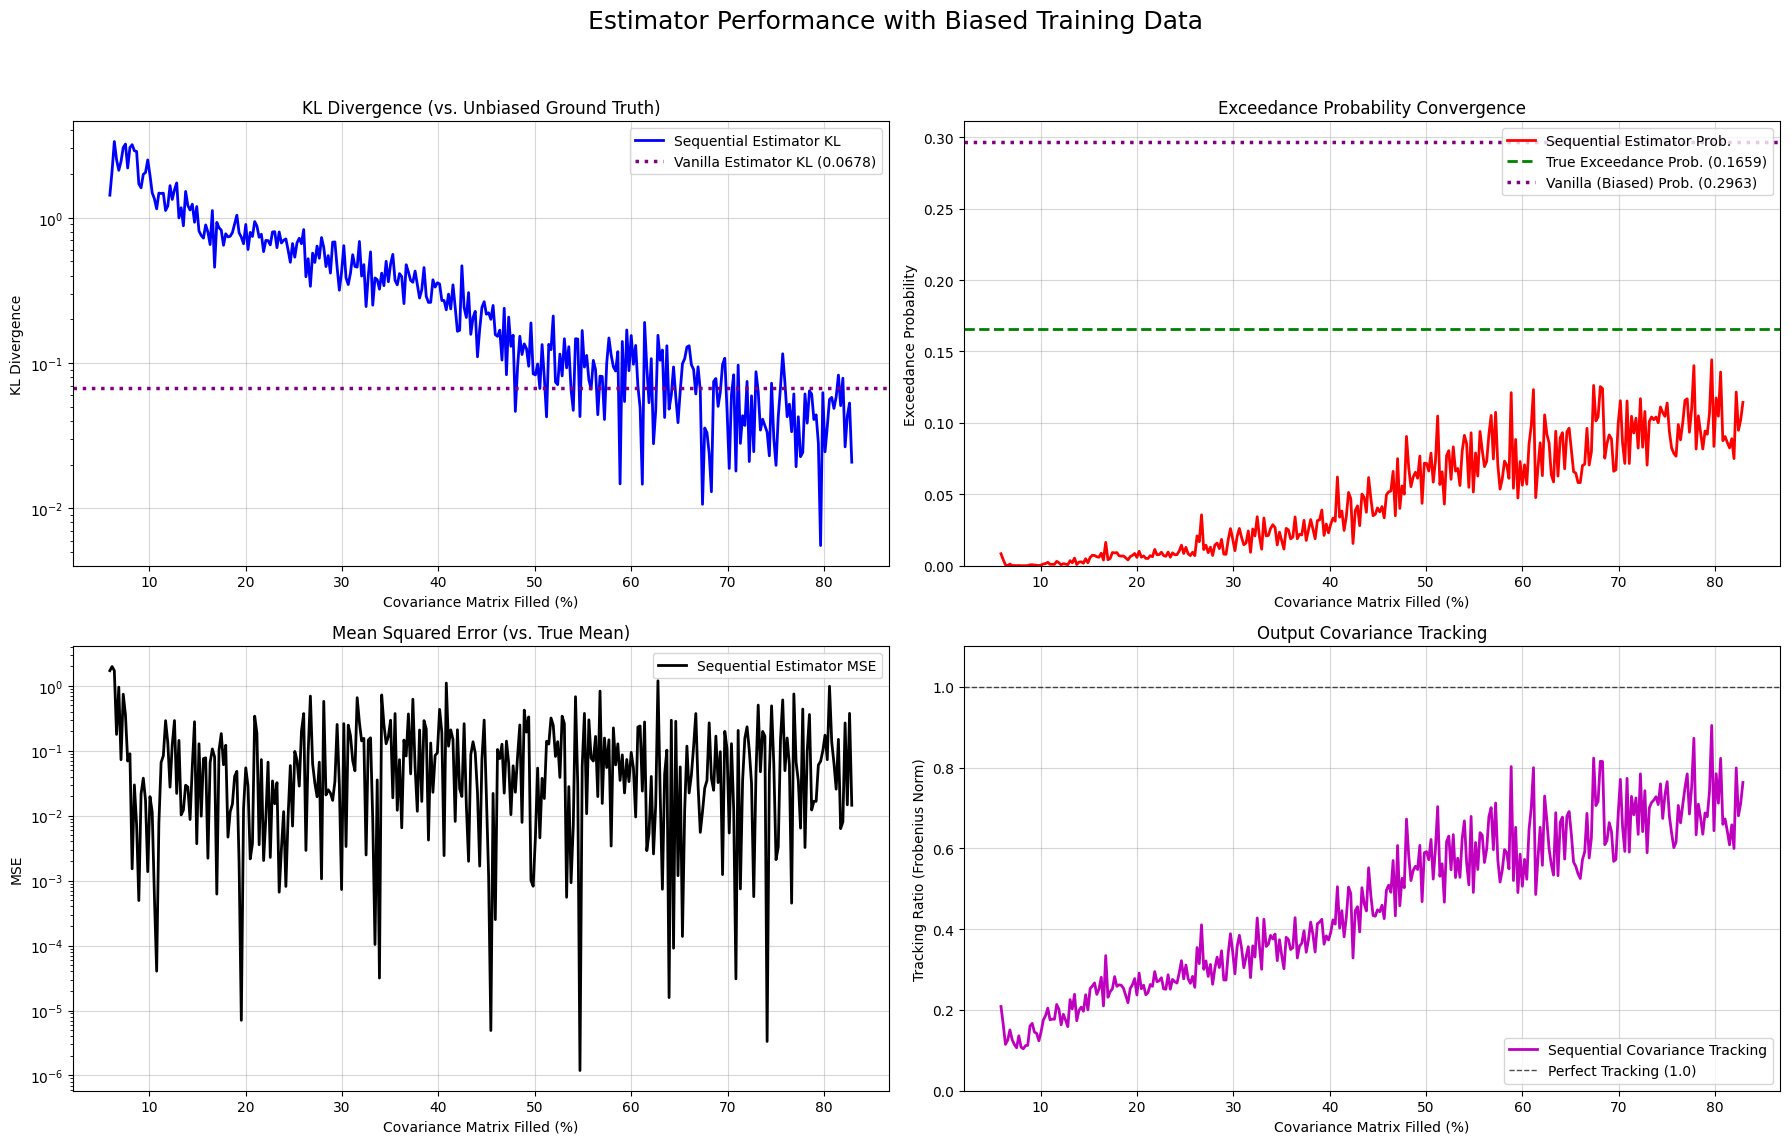


FINAL RESULTS: BIASED TRAINING DATA SCENARIO
Ground Truth Exceedance Probability (from unbiased data): 0.165929
----------------------------------------------------------------------
--- Vanilla Estimator (Trained on BIASED data) ---
Exceedance Probability: 0.296310
  > Error vs. True Prob: 0.130381
KL Divergence to True Distribution: 0.067840
----------------------------------------------------------------------
--- Sequential Estimator (Trained on BIASED data) ---
Final Percentage of Covariance Filled: 82.89%
Exceedance Probability: 0.114352
  > Error vs. True Prob: 0.051577
KL Divergence to True Distribution: 0.020768
Final Covariance Tracking Ratio: 0.763111

Total Ground Truth Samples: 200000 (2% rare events)
Total Training Samples for Estimators: 2000 (0.1% rare events)


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import os
from scipy.stats import norm
from torch.distributions import MultivariateNormal
import matplotlib.pyplot as plt
import copy

# Create output directory for visualizations
os.makedirs('training_visualizations', exist_ok=True)

class DeepNet(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(DeepNet, self).__init__()
        layers = []
        current_size = input_size
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(current_size, hidden_size))
            layers.append(nn.ReLU())
            current_size = hidden_size
        layers.append(nn.Linear(current_size, output_size))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

class FactorGaussian:
    def __init__(self, mean, L_factor, diagonal):
        """Σ = L @ L.T + diag(diagonal)"""
        self.mean = mean
        self.L = L_factor
        self.diagonal = diagonal
        self.n = len(mean) if mean.dim() > 0 else 1
        self.current_rank = L_factor.shape[1]

    def covariance(self):
        stable_diagonal = self.diagonal + 1e-8
        return self.L @ self.L.T + torch.diag(stable_diagonal)

    def get_diagonal(self):
        l_diag = torch.sum(self.L * self.L, dim=1)
        return l_diag + self.diagonal

def propagate_by_sampling(input_distribution, layer_block, mask=None, num_samples=1000):
    input_mean = input_distribution.mean
    input_cov = input_distribution.covariance()
    input_dim = input_mean.shape[0]
    
    epsilon = 1e-6 * torch.eye(input_dim, device=input_mean.device)
    input_dist_sampler = MultivariateNormal(loc=input_mean, covariance_matrix=input_cov + epsilon)
    samples = input_dist_sampler.sample(torch.Size([num_samples]))
    with torch.no_grad():
        output_samples = layer_block(samples)
    
    output_mean = torch.mean(output_samples, dim=0)
    # Handle scalar output for covariance calculation
    if output_mean.dim() == 0:
        mean_subtracted_output = output_samples.squeeze() - output_mean
        full_output_covariance = torch.var(mean_subtracted_output, unbiased=True).reshape(1, 1)
    else:
        mean_subtracted_output = output_samples - output_mean
        full_output_covariance = (1 / (num_samples - 1)) * mean_subtracted_output.T @ mean_subtracted_output


    if mask is None:
        output_dim = full_output_covariance.shape[0]
        mask = set((r, c) for r in range(output_dim) for c in range(output_dim))

    masked_cov = torch.zeros_like(full_output_covariance)
    for r, c in mask:
        if r < masked_cov.shape[0] and c < masked_cov.shape[1]:
            masked_cov[r, c] = full_output_covariance[r, c]
            if r != c:
                masked_cov[c, r] = full_output_covariance[c, r]

    output_diag = torch.diag(full_output_covariance)
    off_diag_cov = masked_cov - torch.diag(torch.diag(masked_cov))
    
    try:
        eigvals, eigvecs = torch.linalg.eigh(off_diag_cov)
        eigvals_positive = torch.clamp(eigvals, min=0)
        sqrt_eigvals = torch.sqrt(eigvals_positive)
        output_L = eigvecs @ torch.diag(sqrt_eigvals)
    except torch.linalg.LinAlgError:
        output_L = torch.zeros_like(off_diag_cov)

    residual_diag = output_diag - torch.sum(output_L * output_L, dim=1)
    
    return FactorGaussian(mean=output_mean, L_factor=output_L, diagonal=torch.clamp(residual_diag, min=0))


def compute_estimator_kl_div(true_output_distribution, predicted_output_distribution):
    mu_true, mu_pred = true_output_distribution.mean, predicted_output_distribution.mean
    sigma_true = true_output_distribution.covariance().detach().cpu().numpy()
    sigma_pred = predicted_output_distribution.covariance().detach().cpu().numpy()
    mu_true, mu_pred = mu_true.detach().cpu().numpy(), mu_pred.detach().cpu().numpy()

    epsilon = 1e-6 * np.eye(sigma_true.shape[0])
    sigma_true_stable, sigma_pred_stable = sigma_true + epsilon, sigma_pred + epsilon

    mu_diff = mu_pred - mu_true
    k = len(mu_true)
    try:
        sigma_pred_inv = np.linalg.inv(sigma_pred_stable)
        trace_term = np.trace(sigma_pred_inv @ sigma_true_stable)
        quad_term = mu_diff.T @ sigma_pred_inv @ mu_diff
        sign_true, logdet_true = np.linalg.slogdet(sigma_true_stable)
        sign_pred, logdet_pred = np.linalg.slogdet(sigma_pred_stable)
        if sign_true <= 0 or sign_pred <= 0: return float('inf')
        log_det_term = logdet_pred - logdet_true
        return 0.5 * (trace_term + quad_term - k + log_det_term)
    except np.linalg.LinAlgError:
        return float('inf')

def compute_estimator_mse(true_output_distribution, predicted_output_distribution):
    true_mean = true_output_distribution.mean
    predicted_mean = predicted_output_distribution.mean
    mse = torch.mean((true_mean - predicted_mean) ** 2)
    return mse.item()

def find_true_distribution_by_sampling(input_distribution, grouped_layers, num_samples=50000):
    print("Computing ground truth output distribution via high-density sampling...")
    current_distribution = input_distribution
    for layer_block in grouped_layers:
        current_distribution = propagate_by_sampling(current_distribution, layer_block, mask=None, num_samples=num_samples)
    print("Ground truth calculation complete.")
    return current_distribution

def find_vanilla_output_distribution(model, input_samples):
    """
    Computes the output distribution by passing all input_samples through the model
    and calculating the statistics of the output. This is the "vanilla" approach.
    """
    print("\nComputing vanilla output distribution from training samples...")
    with torch.no_grad():
        output_samples = model(input_samples)
    
    vanilla_mean = torch.mean(output_samples, dim=0)
    vanilla_cov = torch.cov(output_samples.T) if output_samples.shape[0] > 1 else torch.zeros(output_samples.shape[1], output_samples.shape[1])
    
    if vanilla_cov.dim() == 0:
        vanilla_cov = vanilla_cov.reshape(1, 1)

    try:
        epsilon_diag = 1e-6 * torch.eye(vanilla_cov.shape[0], device=vanilla_cov.device)
        vanilla_L = torch.linalg.cholesky(vanilla_cov + epsilon_diag)
        vanilla_diag = torch.zeros(vanilla_mean.shape[0], device=vanilla_mean.device)
    except torch.linalg.LinAlgError:
        vanilla_L = torch.zeros_like(vanilla_cov)
        vanilla_diag = torch.diag(vanilla_cov)

    print("Vanilla distribution calculation complete.")
    return FactorGaussian(mean=vanilla_mean, L_factor=vanilla_L, diagonal=vanilla_diag)


def calculate_range_exceedance_probability(distribution, lower_bound=-5, upper_bound=5):
    if distribution.mean.dim() == 0:
        mu = distribution.mean.item()
        variance = distribution.get_diagonal().item() if distribution.get_diagonal().dim() == 0 else distribution.get_diagonal()[0].item()
    else:
        mu = distribution.mean[0].item()
        variance = distribution.get_diagonal()[0].item()
        
    sigma = np.sqrt(max(variance, 1e-9))
    prob_below = norm.cdf(lower_bound, loc=mu, scale=sigma)
    prob_above = 1 - norm.cdf(upper_bound, loc=mu, scale=sigma)
    return prob_below + prob_above

def calculate_covariance_tracking_ratio(true_distribution, estimated_distribution):
    true_cov = true_distribution.covariance().detach().cpu().numpy()
    est_cov = estimated_distribution.covariance().detach().cpu().numpy()
    
    true_norm = np.linalg.norm(true_cov, 'fro')
    est_norm = np.linalg.norm(est_cov, 'fro')
    
    if true_norm == 0:
        return 1.0 if est_norm == 0 else 0.0
    return min(est_norm / true_norm, 1.0)

def calculate_total_mask_entries(masks):
    return sum(len(mask) for mask in masks)

def calculate_total_possible_entries(grouped_layers):
    total = 0
    for block in grouped_layers:
        output_dim = get_output_dim_from_block(block)
        total += output_dim * output_dim
    return total

def update_mean_covariance(existing_mean, existing_cov, existing_n, new_data):
    new_n = new_data.shape[0]
    if new_n == 0:
        return existing_mean, existing_cov, existing_n
        
    total_n = existing_n + new_n
    if existing_n == 0:
        new_mean = torch.mean(new_data, dim=0)
        new_cov = torch.cov(new_data.T) if new_n > 1 else torch.zeros_like(existing_cov)
        return new_mean, new_cov, total_n

    new_batch_mean = torch.mean(new_data, dim=0)
    delta = new_batch_mean - existing_mean
    updated_mean = existing_mean + delta * (new_n / total_n)
    
    new_batch_cov = torch.cov(new_data.T) if new_n > 1 else torch.zeros_like(existing_cov)
    updated_cov = ((existing_n - 1) * existing_cov + (new_n - 1) * new_batch_cov + 
                   (new_n * existing_n / total_n) * (delta.unsqueeze(1) @ delta.unsqueeze(0))) / (total_n - 1)

    return updated_mean, updated_cov, total_n


def get_output_dim_from_block(layer_block):
    for layer in reversed(layer_block):
        if hasattr(layer, 'out_features'):
            return layer.out_features
    raise ValueError("Could not find a layer with 'out_features' in the block.")

def update_mask_with_ordering(masks, ordering, step):
    if step < len(ordering):
        layer_idx, i, j = ordering[step]
        if isinstance(masks[layer_idx], list):
            masks[layer_idx] = set(masks[layer_idx])
        masks[layer_idx].add((i, j))
        if i != j:
            masks[layer_idx].add((j, i))
    return masks

def create_perfect_ordering(true_input_dist, model, initial_masks):
    print("\n--- Starting Greedy Search for Optimal Ordering (Based on Ground Truth) ---")
    grouped_layers = []
    temp_block_list = []
    for layer in model.layers:
        temp_block_list.append(layer)
        if isinstance(layer, nn.ReLU):
            grouped_layers.append(nn.Sequential(*temp_block_list))
            temp_block_list = []
    if temp_block_list:
        grouped_layers.append(nn.Sequential(*temp_block_list))

    true_output_distribution = find_true_distribution_by_sampling(true_input_dist, grouped_layers, num_samples=100000)

    current_masks = [set(m) for m in initial_masks]
    optimal_ordering = []
    max_iterations = 2000
    propagation_samples = 1000

    for iteration in range(max_iterations):
        best_choice_this_iteration = None
        best_kl_reduction = 1e-9 # Small positive threshold

        base_dist = true_input_dist
        for l_idx, l_block in enumerate(grouped_layers):
            base_dist = propagate_by_sampling(base_dist, l_block, mask=current_masks[l_idx], num_samples=propagation_samples)
        base_kl = compute_estimator_kl_div(true_output_distribution, base_dist)
        
        candidate_found = False
        for layer_idx, layer_block in enumerate(grouped_layers):
            output_dim = get_output_dim_from_block(layer_block)
            for i in range(output_dim):
                for j in range(i, output_dim):
                    if (i, j) in current_masks[layer_idx]:
                        continue

                    temp_masks = [m.copy() for m in current_masks]
                    temp_masks[layer_idx].add((i, j))
                    if i != j: temp_masks[layer_idx].add((j, i))
                    
                    current_dist = true_input_dist
                    for l_idx_prop, l_block_prop in enumerate(grouped_layers):
                        current_dist = propagate_by_sampling(current_dist, l_block_prop, mask=temp_masks[l_idx_prop], num_samples=propagation_samples)
                    
                    kl = compute_estimator_kl_div(true_output_distribution, current_dist)
                    kl_reduction = base_kl - kl

                    if kl_reduction > best_kl_reduction:
                        best_kl_reduction = kl_reduction
                        best_choice_this_iteration = (layer_idx, i, j)
                        candidate_found = True
        
        if candidate_found:
            layer_to_update, r, c = best_choice_this_iteration
            optimal_ordering.append(best_choice_this_iteration)
            current_masks[layer_to_update].add((r, c))
            if r != c: current_masks[layer_to_update].add((c, r))
            if (iteration + 1) % 10 == 0:
                print(f"Ordering Iteration {iteration+1}: Found new best entry {best_choice_this_iteration} -> KL Reduction: {best_kl_reduction:.6f}")
        else:
            print(f"\nStopping greedy search at iteration {iteration+1}. No further beneficial entries found.")
            break

    print(f"--- Greedy Search Complete. Found an ordering of {len(optimal_ordering)} entries. ---\n")
    return optimal_ordering

# --- 1. Setup: Biased Training Data with a Rare Event Cluster ---
torch.manual_seed(42)
np.random.seed(42)
input_dim = 3

# Distribution 1: The "common" case (98% of data)
common_mean = torch.zeros(input_dim, dtype=torch.float32)
common_cov = torch.tensor([[1.0, 0.7, 0.3], [0.7, 1.5, 0.8], [0.3, 0.8, 2.0]], dtype=torch.float32)
common_sampler = MultivariateNormal(loc=common_mean, covariance_matrix=common_cov)

# Distribution 2: The "rare event" case (2% of data)
rare_mean = torch.tensor([5.0, 5.0, 5.0], dtype=torch.float32)
rare_cov = torch.eye(input_dim, dtype=torch.float32) * 0.5
rare_sampler = MultivariateNormal(loc=rare_mean, covariance_matrix=rare_cov)

# Generate a large, unbiased dataset for GROUND TRUTH
print("Generating a large, unbiased dataset for ground truth...")
n_ground_truth = 200000
n_rare_truth = int(n_ground_truth * 0.02)
n_common_truth = n_ground_truth - n_rare_truth
X_ground_truth = torch.cat([
    common_sampler.sample(torch.Size([n_common_truth])),
    rare_sampler.sample(torch.Size([n_rare_truth]))
], dim=0)
X_ground_truth = X_ground_truth[torch.randperm(n_ground_truth)] # Shuffle

true_input_mean = torch.mean(X_ground_truth, dim=0)
true_input_covariance = torch.cov(X_ground_truth.T)
true_input_L = torch.linalg.cholesky(true_input_covariance)
true_input_diag = torch.zeros(input_dim)
true_input_distribution_full = FactorGaussian(mean=true_input_mean, L_factor=true_input_L, diagonal=true_input_diag)

# Generate a small, BIASED dataset for TRAINING the ESTIMATOR
print("Generating a small, biased subset for estimator training (few rare events)...")
n_train = 2000
n_rare_train = 2 # Only 2 rare samples!
n_common_train = n_train - n_rare_train
X_train = torch.cat([
    common_sampler.sample(torch.Size([n_common_train])),
    rare_sampler.sample(torch.Size([n_rare_train]))
], dim=0)
X_train = X_train[torch.randperm(n_train)] # Shuffle

true_weights = torch.tensor([[2.0], [3.0], [-1.0]], dtype=torch.float32)
y_train = X_train @ true_weights

# --- 2. Model Training (Done Once on the BIASED small dataset) ---
model = DeepNet(input_size=3, hidden_sizes=[12, 24, 12], output_size=1)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
print("Starting model training (on biased dataset)...")
for epoch in range(200):
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    if epoch % 40 == 0: print(f'Epoch {epoch}, Loss: {loss.item():.4f}')
print("Model training complete.")
model.eval()

# --- 3. Pre-computation and Benchmarks ---
grouped_layers = []
temp_block_list = []
for layer in model.layers:
    temp_block_list.append(layer)
    if isinstance(layer, nn.ReLU):
        grouped_layers.append(nn.Sequential(*temp_block_list))
        temp_block_list = []
if temp_block_list: grouped_layers.append(nn.Sequential(*temp_block_list))

true_output_distribution = find_true_distribution_by_sampling(true_input_distribution_full, grouped_layers, num_samples=200000)
true_exceedance_prob = calculate_range_exceedance_probability(true_output_distribution)

vanilla_output_distribution = find_vanilla_output_distribution(model, X_train)
vanilla_exceedance_prob = calculate_range_exceedance_probability(vanilla_output_distribution)
vanilla_kl_div = compute_estimator_kl_div(true_output_distribution, vanilla_output_distribution)

total_possible_entries = calculate_total_possible_entries(grouped_layers)
initial_masks = []
initial_entries = 0
for block in grouped_layers:
    dim = get_output_dim_from_block(block)
    initial_masks.append(set((i, i) for i in range(dim)))
    initial_entries += dim

optimal_ordering = create_perfect_ordering(true_input_distribution_full, model, initial_masks)
num_training_steps = len(optimal_ordering)

# --- 4. Sequential Simulation Loop (Using BIASED TRAINING Data) ---
samples_per_step = 10
propagation_samples = 500
total_samples_seen = 0
estimated_input_mean_raw = torch.zeros(input_dim)
estimated_input_covariance_raw = torch.zeros(input_dim, input_dim)
history_kl, history_exceedance_prob, history_mse, history_covariance_tracking_ratio, history_percent_filled = [], [], [], [], []

masks = [set(m) for m in initial_masks]

print(f"\n--- Starting Sequential Simulation ({num_training_steps} steps) ---")
for step in range(num_training_steps):
    start_idx = total_samples_seen % (len(X_train) - samples_per_step)
    new_samples = X_train[start_idx : start_idx + samples_per_step]
    
    estimated_input_mean_raw, estimated_input_covariance_raw, total_samples_seen = update_mean_covariance(estimated_input_mean_raw, estimated_input_covariance_raw, total_samples_seen, new_samples)
    
    masks = update_mask_with_ordering(masks, optimal_ordering, step)
    
    if total_samples_seen > 1:
        current_entries = calculate_total_mask_entries(masks)
        current_percent = (current_entries / total_possible_entries) * 100
        
        epsilon_diag = 1e-6 * torch.eye(input_dim)
        try:
            L = torch.linalg.cholesky(estimated_input_covariance_raw + epsilon_diag)
            diag = torch.zeros(input_dim)
            estimated_input_dist = FactorGaussian(mean=estimated_input_mean_raw, L_factor=L, diagonal=diag)
        except torch.linalg.LinAlgError:
            L = torch.zeros((input_dim, 1))
            diag = torch.diag(estimated_input_covariance_raw)
            estimated_input_dist = FactorGaussian(mean=estimated_input_mean_raw, L_factor=L, diagonal=diag)

        current_dist = estimated_input_dist
        for layer_idx, layer_block in enumerate(grouped_layers):
            current_dist = propagate_by_sampling(current_dist, layer_block, mask=masks[layer_idx], num_samples=propagation_samples)
        
        estimated_output_distribution = current_dist
        
        kl_div = compute_estimator_kl_div(true_output_distribution, estimated_output_distribution)
        mse = compute_estimator_mse(true_output_distribution, estimated_output_distribution)
        exceedance_prob = calculate_range_exceedance_probability(estimated_output_distribution)
        covariance_tracking_ratio = calculate_covariance_tracking_ratio(true_output_distribution, estimated_output_distribution)
        
        history_percent_filled.append(current_percent)
        history_kl.append(kl_div)
        history_mse.append(mse)
        history_exceedance_prob.append(exceedance_prob)
        history_covariance_tracking_ratio.append(covariance_tracking_ratio)

        if (step + 1) % 100 == 0 or (step + 1) == num_training_steps:
            print(f"Step {step+1}: {current_percent:.2f}% filled, KL Div = {kl_div:.4f}, Est. Exceedance = {exceedance_prob:.4f} (True: {true_exceedance_prob:.4f}), Cov. Ratio = {covariance_tracking_ratio:.4f}")

print("Simulation complete.")

# --- 5. Visualization ---
print("Generating visualizations...")
history_kl = np.array(history_kl)
history_exceedance_prob = np.array(history_exceedance_prob)
history_mse = np.array(history_mse)
history_covariance_tracking_ratio = np.array(history_covariance_tracking_ratio)
history_percent_filled = np.array(history_percent_filled)

fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Estimator Performance with Biased Training Data', fontsize=18)

# KL Divergence
axes[0, 0].plot(history_percent_filled, history_kl, 'b-', linewidth=2, label='Sequential Estimator KL')
axes[0, 0].axhline(y=vanilla_kl_div, color='purple', linestyle=':', linewidth=2.5, label=f'Vanilla Estimator KL ({vanilla_kl_div:.4f})')
axes[0, 0].set_xlabel('Covariance Matrix Filled (%)')
axes[0, 0].set_ylabel('KL Divergence')
axes[0, 0].set_title('KL Divergence (vs. Unbiased Ground Truth)')
axes[0, 0].grid(True, alpha=0.5)
axes[0, 0].legend()
axes[0, 0].set_yscale('log')

# Exceedance Probability
axes[0, 1].plot(history_percent_filled, history_exceedance_prob, 'r-', linewidth=2, label='Sequential Estimator Prob.')
axes[0, 1].axhline(y=true_exceedance_prob, color='g', linestyle='--', linewidth=2, label=f'True Exceedance Prob. ({true_exceedance_prob:.4f})')
axes[0, 1].axhline(y=vanilla_exceedance_prob, color='purple', linestyle=':', linewidth=2.5, label=f'Vanilla (Biased) Prob. ({vanilla_exceedance_prob:.4f})')
axes[0, 1].set_xlabel('Covariance Matrix Filled (%)')
axes[0, 1].set_ylabel('Exceedance Probability')
axes[0, 1].set_title('Exceedance Probability Convergence')
axes[0, 1].grid(True, alpha=0.5)
axes[0, 1].legend()
axes[0, 1].set_ylim(bottom=0)

# MSE
axes[1, 0].plot(history_percent_filled, history_mse, 'k-', linewidth=2, label='Sequential Estimator MSE')
axes[1, 0].set_xlabel('Covariance Matrix Filled (%)')
axes[1, 0].set_ylabel('MSE')
axes[1, 0].set_title('Mean Squared Error (vs. True Mean)')
axes[1, 0].grid(True, alpha=0.5)
axes[1, 0].legend()
axes[1, 0].set_yscale('log')

# Covariance Tracking Ratio
axes[1, 1].plot(history_percent_filled, history_covariance_tracking_ratio, 'm-', linewidth=2, label='Sequential Covariance Tracking')
axes[1, 1].axhline(y=1.0, color='k', linestyle='--', linewidth=1, alpha=0.7, label='Perfect Tracking (1.0)')
axes[1, 1].set_xlabel('Covariance Matrix Filled (%)')
axes[1, 1].set_ylabel('Tracking Ratio (Frobenius Norm)')
axes[1, 1].set_title('Output Covariance Tracking')
axes[1, 1].grid(True, alpha=0.5)
axes[1, 1].legend()
axes[1, 1].set_ylim(0, 1.1)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('training_visualizations/final_comparison_biased_data.png', dpi=300, bbox_inches='tight')
plt.show()

# --- 6. Final Results ---
print("\n" + "="*70)
print("FINAL RESULTS: BIASED TRAINING DATA SCENARIO")
print("="*70)
print(f"Ground Truth Exceedance Probability (from unbiased data): {true_exceedance_prob:.6f}")
print("-" * 70)

# --- Vanilla Estimator Results ---
print("--- Vanilla Estimator (Trained on BIASED data) ---")
print(f"Exceedance Probability: {vanilla_exceedance_prob:.6f}")
print(f"  > Error vs. True Prob: {abs(vanilla_exceedance_prob - true_exceedance_prob):.6f}")
print(f"KL Divergence to True Distribution: {vanilla_kl_div:.6f}")
print("-" * 70)


# --- Sequential Estimator Results ---
print("--- Sequential Estimator (Trained on BIASED data) ---")
if len(history_percent_filled) > 0:
    print(f"Final Percentage of Covariance Filled: {history_percent_filled[-1]:.2f}%")
    print(f"Exceedance Probability: {history_exceedance_prob[-1]:.6f}")
    print(f"  > Error vs. True Prob: {abs(history_exceedance_prob[-1] - true_exceedance_prob):.6f}")
    print(f"KL Divergence to True Distribution: {history_kl[-1]:.6f}")
    print(f"Final Covariance Tracking Ratio: {history_covariance_tracking_ratio[-1]:.6f}")
else:
    print("No metric data was generated for the sequential estimator.")

print("\n" + "="*70)
print(f"Total Ground Truth Samples: {len(X_ground_truth)} (2% rare events)")
print(f"Total Training Samples for Estimators: {len(X_train)} ({n_rare_train / n_train * 100:.1f}% rare events)")
print("="*70)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import os
from scipy.stats import norm
from torch.distributions import MultivariateNormal
import matplotlib.pyplot as plt
import copy

# Create output directory for visualizations
os.makedirs('training_visualizations_new_setting', exist_ok=True)

class DeepNet(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(DeepNet, self).__init__()
        layers = []
        current_size = input_size
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(current_size, hidden_size))
            layers.append(nn.ReLU())
            current_size = hidden_size
        layers.append(nn.Linear(current_size, output_size))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

class FactorGaussian:
    def __init__(self, mean, L_factor, diagonal):
        """Σ = L @ L.T + diag(diagonal)"""
        self.mean = mean
        self.L = L_factor
        self.diagonal = diagonal
        self.n = len(mean)
        self.current_rank = L_factor.shape[1]

    def covariance(self):
        stable_diagonal = self.diagonal + 1e-8
        return self.L @ self.L.T + torch.diag(stable_diagonal)

    def get_diagonal(self):
        l_diag = torch.sum(self.L * self.L, dim=1)
        return l_diag + self.diagonal

def propagate_by_sampling(input_distribution, layer_block, mask=None, num_samples=1000):
    input_mean = input_distribution.mean
    input_cov = input_distribution.covariance()
    input_dim = input_mean.shape[0]

    epsilon = 1e-6 * torch.eye(input_dim, device=input_mean.device)
    input_dist_sampler = MultivariateNormal(loc=input_mean, covariance_matrix=input_cov + epsilon)
    samples = input_dist_sampler.sample(torch.Size([num_samples]))
    with torch.no_grad():
        output_samples = layer_block(samples)

    output_mean = torch.mean(output_samples, dim=0)
    mean_subtracted_output = output_samples - output_mean
    full_output_covariance = (1 / (num_samples - 1)) * mean_subtracted_output.T @ mean_subtracted_output

    if mask is None:
        output_dim = full_output_covariance.shape[0]
        mask = set((r, c) for r in range(output_dim) for c in range(output_dim))

    masked_cov = torch.zeros_like(full_output_covariance)
    for r, c in mask:
        if r < masked_cov.shape[0] and c < masked_cov.shape[1]:
            masked_cov[r, c] = full_output_covariance[r, c]
            if r != c:
                masked_cov[c, r] = full_output_covariance[c, r]

    output_diag = torch.diag(full_output_covariance)
    off_diag_cov = masked_cov - torch.diag(torch.diag(masked_cov))

    try:
        eigvals, eigvecs = torch.linalg.eigh(off_diag_cov)
        eigvals_positive = torch.clamp(eigvals, min=0)
        sqrt_eigvals = torch.sqrt(eigvals_positive)
        output_L = eigvecs @ torch.diag(sqrt_eigvals)
    except torch.linalg.LinAlgError:
        output_L = torch.zeros_like(off_diag_cov)

    residual_diag = output_diag - torch.sum(output_L * output_L, dim=1)

    return FactorGaussian(mean=output_mean, L_factor=output_L, diagonal=torch.clamp(residual_diag, min=0))


def compute_estimator_kl_div(true_output_distribution, predicted_output_distribution):
    mu_true, mu_pred = true_output_distribution.mean, predicted_output_distribution.mean
    sigma_true = true_output_distribution.covariance().detach().cpu().numpy()
    sigma_pred = predicted_output_distribution.covariance().detach().cpu().numpy()
    mu_true, mu_pred = mu_true.detach().cpu().numpy(), mu_pred.detach().cpu().numpy()

    epsilon = 1e-6 * np.eye(sigma_true.shape[0])
    sigma_true_stable, sigma_pred_stable = sigma_true + epsilon, sigma_pred + epsilon

    mu_diff = mu_pred - mu_true
    k = len(mu_true)
    try:
        sigma_pred_inv = np.linalg.inv(sigma_pred_stable)
        trace_term = np.trace(sigma_pred_inv @ sigma_true_stable)
        quad_term = mu_diff.T @ sigma_pred_inv @ mu_diff
        sign_true, logdet_true = np.linalg.slogdet(sigma_true_stable)
        sign_pred, logdet_pred = np.linalg.slogdet(sigma_pred_stable)
        if sign_true <= 0 or sign_pred <= 0: return float('inf')
        log_det_term = logdet_pred - logdet_true
        return 0.5 * (trace_term + quad_term - k + log_det_term)
    except np.linalg.LinAlgError:
        return float('inf')

def compute_estimator_mse(true_output_distribution, predicted_output_distribution):
    true_mean = true_output_distribution.mean
    predicted_mean = predicted_output_distribution.mean
    mse = torch.mean((true_mean - predicted_mean) ** 2)
    return mse.item()

def find_true_distribution_by_sampling(input_distribution, grouped_layers, num_samples=50000):
    print("Computing ground truth output distribution via high-density sampling...")
    current_distribution = input_distribution
    for layer_block in grouped_layers:
        current_distribution = propagate_by_sampling(current_distribution, layer_block, mask=None, num_samples=num_samples)
    print("Ground truth calculation complete.")
    return current_distribution

def find_vanilla_output_distribution(model, input_samples):
    """
    Computes the output distribution by passing all input_samples through the model
    and calculating the statistics of the output. This is the "vanilla" approach.
    """
    print("\nComputing vanilla output distribution from training samples...")
    with torch.no_grad():
        output_samples = model(input_samples)

    vanilla_mean = torch.mean(output_samples, dim=0)
    vanilla_cov = torch.cov(output_samples.T) if output_samples.shape[0] > 1 else torch.zeros(output_samples.shape[1], output_samples.shape[1])

    if vanilla_cov.dim() == 0:
        vanilla_cov = vanilla_cov.reshape(1, 1)

    try:
        epsilon_diag = 1e-6 * torch.eye(vanilla_cov.shape[0], device=vanilla_cov.device)
        vanilla_L = torch.linalg.cholesky(vanilla_cov + epsilon_diag)
        vanilla_diag = torch.zeros(vanilla_mean.shape[0], device=vanilla_mean.device)
    except torch.linalg.LinAlgError:
        vanilla_L = torch.zeros_like(vanilla_cov)
        vanilla_diag = torch.diag(vanilla_cov)

    print("Vanilla distribution calculation complete.")
    return FactorGaussian(mean=vanilla_mean, L_factor=vanilla_L, diagonal=vanilla_diag)


def calculate_range_exceedance_probability(distribution, lower_bound=-5, upper_bound=5):
    if distribution.mean.dim() == 0:
        mu = distribution.mean.item()
        variance = distribution.get_diagonal().item()
    else:
        mu = distribution.mean[0].item()
        variance = distribution.get_diagonal()[0].item()

    sigma = np.sqrt(max(variance, 1e-9))
    prob_below = norm.cdf(lower_bound, loc=mu, scale=sigma)
    prob_above = 1 - norm.cdf(upper_bound, loc=mu, scale=sigma)
    return prob_below + prob_above

def calculate_covariance_tracking_ratio(true_distribution, estimated_distribution):
    true_cov = true_distribution.covariance().detach().cpu().numpy()
    est_cov = estimated_distribution.covariance().detach().cpu().numpy()

    true_norm = np.linalg.norm(true_cov, 'fro')
    est_norm = np.linalg.norm(est_cov, 'fro')

    if true_norm == 0:
        return 1.0 if est_norm == 0 else 0.0
    return min(est_norm / true_norm, 1.0)

def calculate_total_mask_entries(masks):
    return sum(len(mask) for mask in masks)

def calculate_total_possible_entries(grouped_layers):
    total = 0
    for block in grouped_layers:
        output_dim = get_output_dim_from_block(block)
        total += output_dim * output_dim
    return total

def update_mean_covariance(existing_mean, existing_cov, existing_n, new_data):
    new_n = new_data.shape[0]
    if new_n == 0:
        return existing_mean, existing_cov, existing_n

    total_n = existing_n + new_n
    if existing_n == 0:
        new_mean = torch.mean(new_data, dim=0)
        new_cov = torch.cov(new_data.T) if new_n > 1 else torch.zeros_like(existing_cov)
        return new_mean, new_cov, total_n

    new_batch_mean = torch.mean(new_data, dim=0)
    delta = new_batch_mean - existing_mean
    updated_mean = existing_mean + delta * (new_n / total_n)

    new_batch_cov = torch.cov(new_data.T) if new_n > 1 else torch.zeros_like(existing_cov)
    updated_cov = ((existing_n - 1) * existing_cov + (new_n - 1) * new_batch_cov +
                   (new_n * existing_n / total_n) * (delta.unsqueeze(1) @ delta.unsqueeze(0))) / (total_n - 1)

    return updated_mean, updated_cov, total_n


def get_output_dim_from_block(layer_block):
    for layer in reversed(layer_block):
        if hasattr(layer, 'out_features'):
            return layer.out_features
    raise ValueError("Could not find a layer with 'out_features' in the block.")

def update_mask_with_ordering(masks, ordering, step):
    if step < len(ordering):
        layer_idx, i, j = ordering[step]
        if isinstance(masks[layer_idx], list):
            masks[layer_idx] = set(masks[layer_idx])
        masks[layer_idx].add((i, j))
        if i != j:
            masks[layer_idx].add((j, i))
    return masks

def create_perfect_ordering(true_input_dist, model, initial_masks):
    print("\n--- Starting Greedy Search for Optimal Ordering (Based on Ground Truth) ---")
    grouped_layers = []
    temp_block_list = []
    for layer in model.layers:
        temp_block_list.append(layer)
        if isinstance(layer, nn.ReLU):
            grouped_layers.append(nn.Sequential(*temp_block_list))
            temp_block_list = []
    if temp_block_list:
        grouped_layers.append(nn.Sequential(*temp_block_list))

    true_output_distribution = find_true_distribution_by_sampling(true_input_dist, grouped_layers, num_samples=100000)

    current_masks = [set(m) for m in initial_masks]
    optimal_ordering = []
    max_iterations = 2000
    propagation_samples = 1000

    for iteration in range(max_iterations):
        best_choice_this_iteration = None
        best_kl_reduction = 0

        base_dist = true_input_dist
        for l_idx, l_block in enumerate(grouped_layers):
            base_dist = propagate_by_sampling(base_dist, l_block, mask=current_masks[l_idx], num_samples=propagation_samples)
        base_kl = compute_estimator_kl_div(true_output_distribution, base_dist)

        candidate_found = False
        for layer_idx, layer_block in enumerate(grouped_layers):
            output_dim = get_output_dim_from_block(layer_block)
            for i in range(output_dim):
                for j in range(i, output_dim):
                    if (i, j) in current_masks[layer_idx]:
                        continue

                    temp_masks = [m.copy() for m in current_masks]
                    temp_masks[layer_idx].add((i, j))
                    if i != j: temp_masks[layer_idx].add((j, i))

                    current_dist = true_input_dist
                    for l_idx_prop, l_block_prop in enumerate(grouped_layers):
                        current_dist = propagate_by_sampling(current_dist, l_block_prop, mask=temp_masks[l_idx_prop], num_samples=propagation_samples)

                    kl = compute_estimator_kl_div(true_output_distribution, current_dist)
                    kl_reduction = base_kl - kl

                    if kl_reduction > best_kl_reduction:
                        best_kl_reduction = kl_reduction
                        best_choice_this_iteration = (layer_idx, i, j)
                        candidate_found = True

        if candidate_found:
            layer_to_update, r, c = best_choice_this_iteration
            optimal_ordering.append(best_choice_this_iteration)
            current_masks[layer_to_update].add((r, c))
            if r != c: current_masks[layer_to_update].add((c, r))
            if (iteration + 1) % 10 == 0:
                print(f"Ordering Iteration {iteration+1}: Found new best entry {best_choice_this_iteration} -> KL Reduction: {best_kl_reduction:.6f}")
        else:
            print(f"\nStopping greedy search at iteration {iteration+1}. No further beneficial entries found.")
            break

    print(f"--- Greedy Search Complete. Found an ordering of {len(optimal_ordering)} entries. ---\n")
    return optimal_ordering

# --- 1. Setup: Ground Truth vs. Training Data ---
print("="*70)
print("NEW SCENARIO: Low Training Data (150 samples), Deeper Network")
print("="*70)
torch.manual_seed(42)
np.random.seed(42)
input_dim = 3
base_input_mean = torch.zeros(input_dim, dtype=torch.float32)
base_input_covariance = torch.tensor([[1.0, 0.7, 0.3], [0.7, 1.5, 0.8], [0.3, 0.8, 2.0]], dtype=torch.float32)
base_input_sampler = MultivariateNormal(loc=base_input_mean, covariance_matrix=base_input_covariance)

print("Generating a large dataset for ground truth (unchanged)...")
X_ground_truth = base_input_sampler.sample(torch.Size([200000]))
true_input_mean = torch.mean(X_ground_truth, dim=0)
true_input_covariance = torch.cov(X_ground_truth.T)
true_input_L = torch.linalg.cholesky(true_input_covariance)
true_input_diag = torch.zeros(input_dim)
true_input_distribution_full = FactorGaussian(mean=true_input_mean, L_factor=true_input_L, diagonal=true_input_diag)

# <<< CHANGE: Drastically reduced number of training samples
print("Generating a VERY SMALL subset for estimator training (150 samples)...")
X_train = base_input_sampler.sample(torch.Size([150]))
true_weights = torch.tensor([[2.0], [3.0], [-1.0]], dtype=torch.float32)
y_train = X_train @ true_weights

# --- 2. Model Training (Done Once on the small dataset) ---
# <<< CHANGE: Deeper network architecture
model = DeepNet(input_size=3, hidden_sizes=[16, 32, 32, 16], output_size=1)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
print("Starting model training (on VERY SMALL dataset)...")
for epoch in range(250): # Increased epochs slightly for the more complex model
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    if epoch % 50 == 0: print(f'Epoch {epoch}, Loss: {loss.item():.4f}')
print("Model training complete.")
model.eval()

# --- 3. Pre-computation and Benchmarks ---
grouped_layers = []
temp_block_list = []
for layer in model.layers:
    temp_block_list.append(layer)
    if isinstance(layer, nn.ReLU):
        grouped_layers.append(nn.Sequential(*temp_block_list))
        temp_block_list = []
if temp_block_list: grouped_layers.append(nn.Sequential(*temp_block_list))

true_output_distribution = find_true_distribution_by_sampling(true_input_distribution_full, grouped_layers, num_samples=200000)
true_exceedance_prob = calculate_range_exceedance_probability(true_output_distribution)

# Calculate the "Vanilla" benchmark
vanilla_output_distribution = find_vanilla_output_distribution(model, X_train)
vanilla_exceedance_prob = calculate_range_exceedance_probability(vanilla_output_distribution)
vanilla_kl_div = compute_estimator_kl_div(true_output_distribution, vanilla_output_distribution)

total_possible_entries = calculate_total_possible_entries(grouped_layers)
initial_masks = []
initial_entries = 0
for block in grouped_layers:
    dim = get_output_dim_from_block(block)
    initial_masks.append(set((i, i) for i in range(dim)))
    initial_entries += dim

optimal_ordering = create_perfect_ordering(true_input_distribution_full, model, initial_masks)
num_training_steps = len(optimal_ordering)

# --- 4. Sequential Simulation Loop (Using TRAINING Data) ---
samples_per_step = 5 # Reduced step size due to smaller dataset
propagation_samples = 500
total_samples_seen = 0
estimated_input_mean_raw = torch.zeros(input_dim)
estimated_input_covariance_raw = torch.zeros(input_dim, input_dim)
history_kl, history_exceedance_prob, history_mse, history_covariance_tracking_ratio, history_percent_filled = [], [], [], [], []

masks = [set(m) for m in initial_masks]

print(f"\n--- Starting Sequential Simulation ({num_training_steps} steps) ---")
for step in range(num_training_steps):
    start_idx = total_samples_seen % (len(X_train) - samples_per_step)
    new_samples = X_train[start_idx : start_idx + samples_per_step]

    estimated_input_mean_raw, estimated_input_covariance_raw, total_samples_seen = update_mean_covariance(estimated_input_mean_raw, estimated_input_covariance_raw, total_samples_seen, new_samples)

    masks = update_mask_with_ordering(masks, optimal_ordering, step)

    if total_samples_seen > 1:
        current_entries = calculate_total_mask_entries(masks)
        current_percent = (current_entries / total_possible_entries) * 100

        epsilon_diag = 1e-6 * torch.eye(input_dim)
        try:
            L = torch.linalg.cholesky(estimated_input_covariance_raw + epsilon_diag)
            diag = torch.zeros(input_dim)
            estimated_input_dist = FactorGaussian(mean=estimated_input_mean_raw, L_factor=L, diagonal=diag)
        except torch.linalg.LinAlgError:
            L = torch.zeros((input_dim, 1))
            diag = torch.diag(estimated_input_covariance_raw)
            estimated_input_dist = FactorGaussian(mean=estimated_input_mean_raw, L_factor=L, diagonal=diag)

        current_dist = estimated_input_dist
        for layer_idx, layer_block in enumerate(grouped_layers):
            current_dist = propagate_by_sampling(current_dist, layer_block, mask=masks[layer_idx], num_samples=propagation_samples)

        estimated_output_distribution = current_dist

        kl_div = compute_estimator_kl_div(true_output_distribution, estimated_output_distribution)
        mse = compute_estimator_mse(true_output_distribution, estimated_output_distribution)
        exceedance_prob = calculate_range_exceedance_probability(estimated_output_distribution)
        covariance_tracking_ratio = calculate_covariance_tracking_ratio(true_output_distribution, estimated_output_distribution)

        history_percent_filled.append(current_percent)
        history_kl.append(kl_div)
        history_mse.append(mse)
        history_exceedance_prob.append(exceedance_prob)
        history_covariance_tracking_ratio.append(covariance_tracking_ratio)

        if (step + 1) % 100 == 0 or (step + 1) == num_training_steps:
            print(f"Step {step+1}: {current_percent:.2f}% filled, KL Div = {kl_div:.4f}, Est. Exceedance = {exceedance_prob:.4f} (True: {true_exceedance_prob:.4f}), Cov. Ratio = {covariance_tracking_ratio:.4f}")

print("Simulation complete.")

# --- 5. Visualization ---
print("Generating visualizations...")
history_kl = np.array(history_kl)
history_exceedance_prob = np.array(history_exceedance_prob)
history_mse = np.array(history_mse)
history_covariance_tracking_ratio = np.array(history_covariance_tracking_ratio)
history_percent_filled = np.array(history_percent_filled)

fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('NEW SETTING: Sequential Estimator vs. Vanilla (Low Data, High Complexity)', fontsize=18)

# KL Divergence
axes[0, 0].plot(history_percent_filled, history_kl, 'b-', linewidth=2, label='Sequential Estimator KL')
axes[0, 0].axhline(y=vanilla_kl_div, color='purple', linestyle=':', linewidth=2.5, label=f'Vanilla Estimator KL ({vanilla_kl_div:.4f})')
axes[0, 0].set_xlabel('Covariance Matrix Filled (%)')
axes[0, 0].set_ylabel('KL Divergence')
axes[0, 0].set_title('KL Divergence (Estimator vs. Ground Truth)')
axes[0, 0].grid(True, alpha=0.5)
axes[0, 0].legend()
axes[0, 0].set_yscale('log')

# Exceedance Probability
axes[0, 1].plot(history_percent_filled, history_exceedance_prob, 'r-', linewidth=2, label='Sequential Estimator Prob.')
axes[0, 1].axhline(y=true_exceedance_prob, color='g', linestyle='--', linewidth=2, label=f'True Exceedance Prob. ({true_exceedance_prob:.4f})')
axes[0, 1].axhline(y=vanilla_exceedance_prob, color='purple', linestyle=':', linewidth=2.5, label=f'Vanilla Exceedance Prob. ({vanilla_exceedance_prob:.4f})')
axes[0, 1].set_xlabel('Covariance Matrix Filled (%)')
axes[0, 1].set_ylabel('Exceedance Probability')
axes[0, 1].set_title('Exceedance Probability Convergence')
axes[0, 1].grid(True, alpha=0.5)
axes[0, 1].legend()
axes[0, 1].set_ylim(bottom=0)

# MSE
axes[1, 0].plot(history_percent_filled, history_mse, 'k-', linewidth=2, label='Sequential Estimator MSE')
axes[1, 0].set_xlabel('Covariance Matrix Filled (%)')
axes[1, 0].set_ylabel('MSE')
axes[1, 0].set_title('Mean Squared Error (Estimator vs. Ground Truth)')
axes[1, 0].grid(True, alpha=0.5)
axes[1, 0].legend()
axes[1, 0].set_yscale('log')

# Covariance Tracking Ratio
axes[1, 1].plot(history_percent_filled, history_covariance_tracking_ratio, 'm-', linewidth=2, label='Sequential Covariance Tracking')
axes[1, 1].axhline(y=1.0, color='k', linestyle='--', linewidth=1, alpha=0.7, label='Perfect Tracking (1.0)')
axes[1, 1].set_xlabel('Covariance Matrix Filled (%)')
axes[1, 1].set_ylabel('Tracking Ratio (Frobenius Norm)')
axes[1, 1].set_title('Output Covariance Tracking')
axes[1, 1].grid(True, alpha=0.5)
axes[1, 1].legend()
axes[1, 1].set_ylim(0, 1.1)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('training_visualizations_new_setting/final_comparison_new_setting.png', dpi=300, bbox_inches='tight')
plt.show()

# --- 6. Final Results ---
print("\n" + "="*70)
print("FINAL RESULTS: NEW 'LOW DATA, HIGH COMPLEXITY' SCENARIO")
print("="*70)
print(f"Ground Truth Exceedance Probability: {true_exceedance_prob:.6f}")
print("-" * 70)

# --- Vanilla Estimator Results ---
print("--- Vanilla Estimator (Based on only 150 training samples at once) ---")
print(f"Exceedance Probability: {vanilla_exceedance_prob:.6f}")
print(f"  > Error vs. True Prob: {abs(vanilla_exceedance_prob - true_exceedance_prob):.6f}")
print(f"KL Divergence to True Distribution: {vanilla_kl_div:.6f}")
print("-" * 70)


# --- Sequential Estimator Results ---
print("--- Sequential Estimator (Final State) ---")
if len(history_percent_filled) > 0:
    print(f"Final Percentage of Covariance Filled: {history_percent_filled[-1]:.2f}%")
    print(f"Exceedance Probability: {history_exceedance_prob[-1]:.6f}")
    print(f"  > Error vs. True Prob: {abs(history_exceedance_prob[-1] - true_exceedance_prob):.6f}")
    print(f"KL Divergence to True Distribution: {history_kl[-1]:.6f}")
    print(f"Final Covariance Tracking Ratio: {history_covariance_tracking_ratio[-1]:.6f}")
else:
    print("No metric data was generated for the sequential estimator.")

print("\n" + "="*70)
print(f"Total Ground Truth Samples: {len(X_ground_truth)}")
print(f"Total Training Samples for Estimators: {len(X_train)}")
print("="*70)

NEW SCENARIO: Low Training Data (150 samples), Deeper Network


KeyboardInterrupt: 